# Enhancing Recommendation Systems: A Comparative Analysis of Multimodal Feature Representations

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["CUDA_LAUNCH_BLOCKING"]="0"

In [ ]:
import torch
import random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from numpy.ma import masked_where

In [ ]:
!pip install torchsampler

  Using cached torchsampler-0.1.2-py3-none-any.whl (5.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)


In [ ]:
from sklearn.preprocessing import normalize
from torch.utils.data import Dataset, DataLoader
from torchsampler import ImbalancedDatasetSampler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

In [ ]:
items = pd.read_csv("items.csv")

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('u1.base', sep='\t', names=r_cols,encoding='latin-1')

In [ ]:
n_users = 943
n_items = 1682

In [ ]:
data_matrix = np.zeros((n_users, n_items))
for line in ratings.itertuples():
    data_matrix[line[1]-1, line[2]-1] = line[3]

In [ ]:
data_matrix_emp = data_matrix.copy()
data_matrix_emp[data_matrix < 4] = 0
data_matrix_emp[data_matrix >= 4]= 1

In [ ]:
train_indices = list(zip(*(np.where(data_matrix != 0))))

In [ ]:
torch.cuda.is_available()

False

In [ ]:
torch.__version__

'2.2.1+cu121'

In [ ]:
items_csv = "items.csv"
train_ratings = "u1.base"
test_ratings = "u1.test"

item_path = ""
ROW = 30
BATCH = 2000

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class MovielensDataset(Dataset):
    def __init__(self, ratings = train_ratings, item_path = item_path, device = device):
        self.item_path = item_path
        self.video_embeddings = pd.read_csv(item_path + "embeddings(video).csv").to_numpy()
        self.audio_embeddings = pd.read_csv(item_path + "embeddings(audiio).csv").to_numpy()
        self.meta_embeddings = pd.read_csv(item_path + "embeddings(meta).csv").to_numpy()
        self.text_embeddings = pd.read_csv(item_path + "embeddings(text).csv").to_numpy()
        self.ratings = pd.read_csv(ratings, sep='\t',
                                   names=['user_id', 'movie_id', 'rating', 'unix_timestamp'],encoding='latin-1')
        self.indices = None
        self.device = device
        self.data = None
        self.n_users = None
        self.n_items = None
        self.fill_ratings()
        self.embeddings()

    def fill_ratings(self, threshold=4):
        self.n_users = self.ratings.user_id.unique().shape[0]
        self.n_items = self.ratings.movie_id.unique().shape[0]

        self.data = np.zeros((n_users, n_items))
        for line in self.ratings.itertuples():
            self.data[line[1]-1, line[2]-1] = line[3]

        self.data_emp = np.where(np.logical_and(self.data > 3,
                            np.random.random_sample(self.data.shape) <= 0.2), 1, 0)
        self.indices = list(zip(*(np.where(self.data != 0))))

    def embeddings(self):
        print(self.video_embeddings.shape)
        self.audio_embeddings = normalize(self.audio_embeddings, axis = 0)
        self.video_embeddings = normalize(self.video_embeddings, axis = 0)
        self.user_embeddings = np.divide(np.dot(self.data_emp, self.meta_embeddings),
                                         self.data_emp.sum(axis = 1)[:, None] + 0.001)
#         self.user_embeddings = data_matrix
        self.item_embeddings = data_matrix.T
        self.video_embedding_size = self.video_embeddings.shape[1]
        self.audio_embedding_size = self.audio_embeddings.shape[1]
        self.text_embedding_size = self.text_embeddings.shape[1]
        self.user_embedding_size = self.user_embeddings.shape[1]
        self.item_embedding_size = self.item_embeddings.shape[1]
        self.meta_embedding_size = self.meta_embeddings.shape[1]

    def __len__(self):
        return(len(self.indices))

    def __getitem__(self, idx):
        user = self.indices[idx][0]
        item = self.indices[idx][1]

#         xu = self.user_embeddings(torch.LongTensor([user])).squeeze().to(self.device)
        xu = torch.from_numpy(self.user_embeddings[user]).to(self.device)
        xa = torch.from_numpy(self.audio_embeddings[item]).to(self.device)
        xv = torch.from_numpy(self.video_embeddings[item]).to(self.device)
        xt = torch.from_numpy(self.text_embeddings[item]).to(self.device)
        xi = torch.from_numpy(self.item_embeddings[item]).to(self.device)
        xm = torch.from_numpy(self.meta_embeddings[item]).to(self.device)

        y = self.data[user][item]
        return(xu.float(), [xv.float(), xa.float(), xt.float(), xi.float(), xm.float()], int(y))

In [ ]:
train_dataset = MovielensDataset(ratings = train_ratings)
test_dataset = MovielensDataset(ratings = test_ratings)

(1682, 1024)
(1682, 1024)


In [ ]:
trainloader = DataLoader(train_dataset, batch_size = BATCH, shuffle = True)
testloader = DataLoader(test_dataset, batch_size = BATCH, shuffle = False)

for i, data in tqdm(enumerate(trainloader)):
                #self.train()
                x1, x2, y = data
                print(len(x2[0]))
                break

0it [00:00, ?it/s]

2000


In [ ]:
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import OrderedDict

In [ ]:
weight = np.array([np.count_nonzero(train_dataset.data == i) for i in range(1, 6)])
weight = weight.max() / weight
weight = torch.Tensor(weight).to(device)

In [ ]:
def weighted_mse_loss(pred, target, weight=weight):
    target = target.long()
    weight = weight[target - 1].to(pred.dtype)
    loss = (pred - target.to(pred.dtype)).pow(2)
    return ((weight * loss).mean(), loss.mean())

In [ ]:
class SiameseNet(nn.Module):
    def __init__(self, device = device, channel = 84):
        super(SiameseNet, self).__init__()
        self.encoder_user = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.user_embedding_size, 1024)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1024, channel)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_item = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.item_embedding_size, 256)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(256, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_video = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.video_embedding_size, 1600)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1600, 300)),
            ('relu2', nn.LeakyReLU()),
#             ('linr3', nn.Linear(1000, 500)),
#             ('relu3', nn.LeakyReLU()),
# #             ('norm2', nn.BatchNorm1d(500)),
#             ('linr4', nn.Linear(500, 300)),
#             ('relu4', nn.LeakyReLU()),
        ]))

        self.encoder_audio = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.audio_embedding_size, 600)),
            ('relu1', nn.LeakyReLU()),
            ('linr4', nn.Linear(600, 300)),
            ('relu4', nn.LeakyReLU()),
        ]))

        self.encoder_text = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.text_embedding_size, 256)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(256, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_meta = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.meta_embedding_size, 1600)),
            ('relu1', nn.LeakyReLU()),
#             ('norm1', nn.BatchNorm1d(1600)),
            ('linr2', nn.Linear(1600, 300)),
            ('relu2', nn.LeakyReLU()),
#             ('linr3', nn.Linear(1000, 500)),
#             ('relu3', nn.LeakyReLU()),
#             ('linr4', nn.Linear(500, 300)),
#             ('relu4', nn.LeakyReLU()),
        ]))

        self.fusion = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, 1, (20, 20), stride=(2, 2))),
            ('relu1', nn.LeakyReLU()),
            ('conv2', nn.Conv2d(1, 1, (5, 50), stride=(1, 1))),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.siamese = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(channel, 200)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(200, 256)),
            ('relu2', nn.LeakyReLU()),
            ('linr3', nn.Linear(256, 100)),
            ('relu3', nn.LeakyReLU()),
        ]))

        self.ffn = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(300, 164)),
            ('actv1', nn.ReLU()),
            ('linr2', nn.Linear(164, 1)),
#             ('actv2', nn.ReLU()),
#             ('linr3', nn.Linear(50, 1)),
        ]))

        self.device = device
        self.encoder_user.apply(self.init_weights)
        self.encoder_item.apply(self.init_weights)
        self.encoder_video.apply(self.init_weights)
        self.encoder_audio.apply(self.init_weights)
        self.encoder_text.apply(self.init_weights)
        self.encoder_meta.apply(self.init_weights)
        self.siamese.apply(self.init_weights)
        self.ffn.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

    def exp(self, q, k, v):
        z = torch.bmm(q, k.permute(0, 2, 1))
        z = F.normalize(z, p = 10, dim = 1)
        z = torch.softmax(z, 1)
        z = torch.bmm(z, v)
        return(z)

    def forward(self, x1, x2):
        # Modality-encoders
        outu = self.encoder_user(x1)
        outr = self.encoder_item(x2[3])
        outv = torch.split(self.encoder_video(x2[0]), [100, 100, 100], 1)
        outa = torch.split(self.encoder_audio(x2[1]), [100, 100, 100], 1)
        outt = torch.split(self.encoder_text(x2[2]), 100, 1)
        outm = torch.split(self.encoder_meta(x2[4]), [100, 100, 100], 1)

        # Attention
        q_t = outt[0].unsqueeze(1).repeat(1, ROW, 1)
        k_t = outt[1].unsqueeze(1).repeat(1, ROW, 1)
        v_t = outt[2].unsqueeze(1).repeat(1, ROW, 1)

        q_a = outa[0].unsqueeze(1).repeat(1, ROW, 1)
        k_a = outa[1].unsqueeze(1).repeat(1, ROW, 1)
        v_a = outa[2].unsqueeze(1).repeat(1, ROW, 1)

        q_v = outv[0].unsqueeze(1).repeat(1, ROW, 1)
        k_v = outv[1].unsqueeze(1).repeat(1, ROW, 1)
        v_v = outv[2].unsqueeze(1).repeat(1, ROW, 1)

        q_m = outm[0].unsqueeze(1).repeat(1, ROW, 1)
        k_m = outm[1].unsqueeze(1).repeat(1, ROW, 1)
        v_m = outm[2].unsqueeze(1).repeat(1, ROW, 1)

        # Self-Attention
        st = self.exp(q_t, k_t, v_t)
        sm = self.exp(q_m, k_m, v_m)
        sa = self.exp(q_a, k_a, v_a)
        sv = self.exp(q_v, k_v, v_v)

        # Inter-Modal Attention
        ita = self.exp(q_a, k_t, v_a)
        imv = self.exp(q_v, k_m, v_v)
        itm = self.exp(q_m, k_t, v_m)

        # Forward
        ma = torch.mean(torch.stack([sa, ita]), 0)
        mv = torch.mean(torch.stack([sv, imv]), 0)
        sda = itm
        se = torch.mul(ma, mv)
        outi = torch.cat((sda, se), axis = 2)#.reshape(-1, ROW * 1200)
        outi = self.fusion(outi.unsqueeze(1))
        out1 = self.siamese(outu)
        out2 = self.siamese(outi.reshape(BATCH, -1))
        diff = torch.cat((out1, out2, outm[2]), axis=1)
        out = self.ffn(diff)
        return(out, out1, out2)

    def fit(self, trainloader = trainloader,
            testloader = testloader, epochs = 1):
        self.criterion_rate = weighted_mse_loss
        self.criterion_embd = nn.CosineEmbeddingLoss()
        self.optimizer = optim.Adam(self.parameters(), lr = 1e-4)

        train_loss = []
        train_f1 = []
        test_loss = []
        test_f1 = []
        for epoch in range(epochs):
            running_loss = 0.0
            running_loss_1 = 0.0

            for i, data in tqdm(enumerate(trainloader)):
                self.train()
                x1, x2, y = data
                y_flt = y.type(torch.FloatTensor).to(device)
                y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
                self.optimizer.zero_grad()
                reg, outu, outi = self.forward(x1, x2)
                loss_1, loss_ = self.criterion_rate(reg.squeeze(), y_flt)
                loss_2 = self.criterion_embd(outu, outi, y_lng * 2 - 1)
                loss = loss_1 + loss_2
                loss.backward()
                self.optimizer.step()

                running_loss_1 += torch.sqrt(loss_)
                running_loss += loss
            vl, vp, vr, vf, tp, tr, tf = self.evaluate()
            print('Epoch-%d: Loss = %.3f\nTrain RMSE = %.3f||Train Precision = %.3f||Train Recall = %.3f\nTest RMSE = %.3f || Test Precision = %.3f|| Test Recall = %.3f'%
                  (epoch + 1, running_loss / i, running_loss_1 / i,
                   tp, tr, vl, vp, vr))
            train_loss.append((running_loss_1 / i).cpu().detach().numpy())
            test_loss.append(vl.cpu().detach().numpy())
            train_f1.append(tf)
            test_f1.append(vf)
        return(train_loss, test_loss, train_f1, test_f1)

    def evaluate(self, k = 3.5):
        self.eval()
        with torch.no_grad():
            valdata = next(iter(testloader))
            x1, x2, y = valdata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            vl = torch.sqrt(self.criterion_rate(otpt[0].squeeze(), y_flt)[1])
            vp = precision_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            vr = recall_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            vf = f1_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            print(classification_report(y_lng.cpu(), pred.cpu(),
                    target_names = ["0", "1"], zero_division = 0))

            traindata = next(iter(trainloader))
            x1, x2, y = traindata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            tp = precision_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            tr = recall_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            tf = f1_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
        return(vl, vp*100, vr*100, vf*100, tp*100, tr*100, tf*100)

In [ ]:
sm_net = SiameseNet()
sm_net.to(device)

SiameseNet(
  (encoder_user): Sequential(
    (linr1): Linear(in_features=1220, out_features=1024, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1024, out_features=84, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_item): Sequential(
    (linr1): Linear(in_features=943, out_features=256, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=256, out_features=300, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_video): Sequential(
    (linr1): Linear(in_features=1024, out_features=1600, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1600, out_features=300, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_audio): Sequential(
    (linr1): Linear(in_features=1024, out_features=600, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr4): Linear(in_features=600, out_features=300, bias=True)
    (relu4):

In [ ]:
train_loss, test_loss, train_f1, test_f1 = sm_net.fit()

40it [00:50,  1.26s/it]


              precision    recall  f1-score   support

           0       0.43      1.00      0.60       865
           1       0.71      0.00      0.01      1135

    accuracy                           0.43      2000
   macro avg       0.57      0.50      0.31      2000
weighted avg       0.59      0.43      0.27      2000

Epoch-1: Loss = 7.477
Train RMSE = 1.973||Train Precision = 81.818||Train Recall = 0.840
Test RMSE = 1.584 || Test Precision = 71.429|| Test Recall = 0.441


In [ ]:
torch.save(sm_net, "./attention.pth")

In [ ]:
sm_net.evaluate(k=3.5)

              precision    recall  f1-score   support

           0       0.43      1.00      0.60       865
           1       0.71      0.00      0.01      1135

    accuracy                           0.43      2000
   macro avg       0.57      0.50      0.31      2000
weighted avg       0.59      0.43      0.27      2000



(tensor(1.5837, device='cuda:0'),
 71.42857142857143,
 0.4405286343612335,
 0.8756567425569177,
 71.42857142857143,
 0.4549590536851683,
 0.9041591320072331)

<ipython-input-25-abf663b56279>:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")


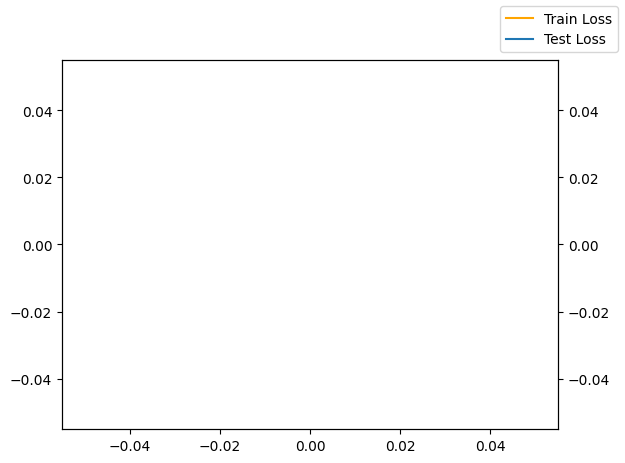

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(train_loss[20:], label = "Train Loss", color = "orange")
ax2.plot(test_loss[20:], label = "Test Loss")
fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torch

In [ ]:
sm_net = torch.load("./attention.pth")

              precision    recall  f1-score   support

           0       0.44      0.73      0.55       865
           1       0.59      0.30      0.40      1135

    accuracy                           0.49      2000
   macro avg       0.52      0.52      0.48      2000
weighted avg       0.53      0.49      0.47      2000

              precision    recall  f1-score   support

           0       0.44      0.83      0.58       865
           1       0.62      0.21      0.31      1135

    accuracy                           0.48      2000
   macro avg       0.53      0.52      0.44      2000
weighted avg       0.54      0.48      0.43      2000

              precision    recall  f1-score   support

           0       0.44      0.91      0.59       865
           1       0.63      0.12      0.20      1135

    accuracy                           0.46      2000
   macro avg       0.54      0.51      0.40      2000
weighted avg       0.55      0.46      0.37      2000

              preci

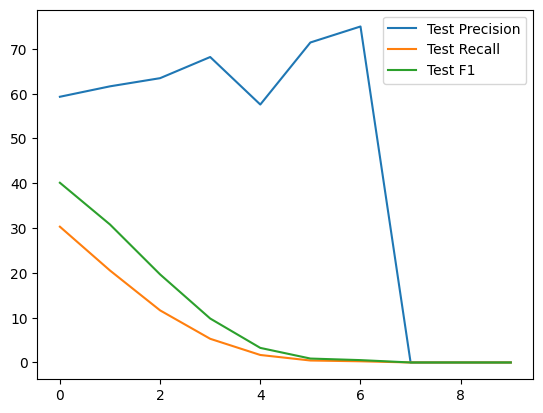

In [ ]:
prs = []
rec = []
f1 = []
loss = []

for i in np.arange(3, 4, 0.1):
    l, p, r, f, _, _, _ = sm_net.evaluate(i)
    prs.append(p)
    rec.append(r)
    f1.append(f)
    loss.append(l)

plt.plot(prs, label = "Test Precision")
plt.plot(rec, label = "Test Recall")
plt.plot(f1, label = "Test F1")

plt.legend()
plt.show()

# **2(Meta+Audio)**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from collections import OrderedDict
from tqdm import tqdm

class SiameseNet1(nn.Module):
    def __init__(self, device=device, channel=84):
        super(SiameseNet1, self).__init__()
        self.encoder_user = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.user_embedding_size, 1024)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1024, channel)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_item = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.item_embedding_size, 256)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(256, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))



        self.encoder_audio = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.audio_embedding_size, 600)),
            ('relu1', nn.LeakyReLU()),
            ('linr4', nn.Linear(600, 300)),
            ('relu4', nn.LeakyReLU()),
        ]))


        self.encoder_meta = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.meta_embedding_size, 1600)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1600, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.fusion = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, 1, (20, 20), stride=(2, 2))),
            ('relu1', nn.LeakyReLU()),
            ('conv2', nn.Conv2d(1, 1, (5, 50), stride=(1, 1))),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.siamese = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(channel, 200)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(200, 256)),
            ('relu2', nn.LeakyReLU()),
            ('linr3', nn.Linear(256, 100)),
            ('relu3', nn.LeakyReLU()),
        ]))

        self.ffn = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(300, 164)),
            ('actv1', nn.ReLU()),
            ('linr2', nn.Linear(164, 1)),
        ]))

        self.device = device
        self.encoder_user.apply(self.init_weights)
        self.encoder_item.apply(self.init_weights)
        self.encoder_audio.apply(self.init_weights)
        self.encoder_meta.apply(self.init_weights)
        self.siamese.apply(self.init_weights)
        self.ffn.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

    def exp(self, q, k, v):
        z = torch.bmm(q, k.permute(0, 2, 1))
        z = F.normalize(z, p=10, dim=1)
        z = torch.softmax(z, 1)
        z = torch.bmm(z, v)
        return z

    def forward(self, x1, x2):
        # Modality-encoders
        outu = self.encoder_user(x1)
        outr = self.encoder_item(x2[3])
        outa = torch.split(self.encoder_audio(x2[1]), [100, 100, 100], 1)
        outm = torch.split(self.encoder_meta(x2[4]), [100, 100, 100], 1)

        # Attention

        q_a = outa[0].unsqueeze(1).repeat(1, ROW, 1)
        k_a = outa[1].unsqueeze(1).repeat(1, ROW, 1)
        v_a = outa[2].unsqueeze(1).repeat(1, ROW, 1)


        q_m = outm[0].unsqueeze(1).repeat(1, ROW, 1)
        k_m = outm[1].unsqueeze(1).repeat(1, ROW, 1)
        v_m = outm[2].unsqueeze(1).repeat(1, ROW, 1)

        # Self-Attention
        sm = self.exp(q_m, k_m, v_m)
        sa = self.exp(q_a, k_a, v_a)

        # Inter-Modal Attention
        ita = self.exp(q_a, k_a, v_a)
        # imv = self.exp(q_v, k_m, v_v)
        itm = self.exp(q_m, k_m, v_m)

        # Forward
        ma = torch.mean(torch.stack([sa, ita]), 0)
        mv = torch.mean(torch.stack([sm, itm]), 0)
        sda = itm
        se = torch.mul(ma, mv)
        outi = torch.cat((sda, se), axis=2)
        outi = self.fusion(outi.unsqueeze(1))
        out1 = self.siamese(outu)
        out2 = self.siamese(outi.reshape(BATCH, -1))
        diff = torch.cat((out1, out2, outm[2]), axis=1)
        out = self.ffn(diff)
        return out, out1, out2

    def fit(self, trainloader=trainloader, testloader=testloader, epochs=1):
        self.criterion_rate = weighted_mse_loss
        self.criterion_embd = nn.CosineEmbeddingLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=1e-4)

        train_loss = []
        train_f1 = []
        test_loss = []
        test_f1 = []
        for epoch in range(epochs):
            running_loss = 0.0
            running_loss_1 = 0.0

            for i, data in tqdm(enumerate(trainloader)):
                self.train()
                x1, x2, y = data
                y_flt = y.type(torch.FloatTensor).to(device)
                y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
                self.optimizer.zero_grad()
                reg, outu, outi = self.forward(x1, x2)
                loss_1, loss_ = self.criterion_rate(reg.squeeze(), y_flt)
                loss_2 = self.criterion_embd(outu, outi, y_lng * 2 - 1)
                loss = loss_1 + loss_2
                loss.backward()
                self.optimizer.step()

                running_loss_1 += torch.sqrt(loss_)
                running_loss += loss
            vl, vp, vr, vf, tp, tr, tf = self.evaluate()
            print('Epoch-%d: Loss = %.3f\nTrain RMSE = %.3f||Train Precision = %.3f||Train Recall = %.3f\nTest RMSE = %.3f || Test Precision = %.3f|| Test Recall = %.3f'%
                  (epoch + 1, running_loss / i, running_loss_1 / i,
                   tp, tr, vl, vp, vr))
            train_loss.append((running_loss_1 / i).cpu().detach().numpy())
            test_loss.append(vl.cpu().detach().numpy())
            train_f1.append(tf)
            test_f1.append(vf)
        return train_loss, test_loss, train_f1, test_f1

    def evaluate(self, k=3.5):
        self.eval()
        with torch.no_grad():
            valdata = next(iter(testloader))
            x1, x2, y = valdata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            vl = torch.sqrt(self.criterion_rate(otpt[0].squeeze(), y_flt)[1])
            vp = precision_score(y_lng.cpu(), pred.cpu(), zero_division=0)
            vr = recall_score(y_lng.cpu(), pred.cpu(), zero_division=0)
            vf = f1_score(y_lng.cpu(), pred.cpu(), zero_division=0)
            print(classification_report(y_lng.cpu(), pred.cpu(),
                    target_names=["0", "1"], zero_division=0))

            traindata = next(iter(trainloader))
            x1, x2, y = traindata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            tp = precision_score(y_lng.cpu(), pred.cpu(), zero_division=0)
            tr = recall_score(y_lng.cpu(), pred.cpu(), zero_division=0)
            tf = f1_score(y_lng.cpu(), pred.cpu(), zero_division=0)
        return vl, vp*100, vr*100, vf*100, tp*100, tr*100, tf*100

# Update the changes in this code


In [ ]:
sm_net = SiameseNet1()
sm_net.to(device)

SiameseNet1(
  (encoder_user): Sequential(
    (linr1): Linear(in_features=1220, out_features=1024, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1024, out_features=84, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_item): Sequential(
    (linr1): Linear(in_features=943, out_features=256, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=256, out_features=300, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_audio): Sequential(
    (linr1): Linear(in_features=1024, out_features=600, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr4): Linear(in_features=600, out_features=300, bias=True)
    (relu4): LeakyReLU(negative_slope=0.01)
  )
  (encoder_meta): Sequential(
    (linr1): Linear(in_features=1220, out_features=1600, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1600, out_features=300, bias=True)
    (relu2):

In [ ]:
train_loss, test_loss, train_f1, test_f1 = sm_net.fit()

40it [00:31,  1.26it/s]


              precision    recall  f1-score   support

           0       0.44      0.97      0.60       865
           1       0.71      0.06      0.11      1135

    accuracy                           0.45      2000
   macro avg       0.58      0.51      0.36      2000
weighted avg       0.60      0.45      0.33      2000

Epoch-1: Loss = 8.713
Train RMSE = 2.186||Train Precision = 71.667||Train Recall = 4.060
Test RMSE = 1.554 || Test Precision = 71.429|| Test Recall = 6.167


In [ ]:
torch.save(sm_net, "./attention.pth")

In [ ]:
sm_net.evaluate(k=3.5)

              precision    recall  f1-score   support

           0       0.44      0.97      0.60       865
           1       0.71      0.06      0.11      1135

    accuracy                           0.45      2000
   macro avg       0.58      0.51      0.36      2000
weighted avg       0.60      0.45      0.33      2000



(tensor(1.5541, device='cuda:0'),
 71.42857142857143,
 6.167400881057269,
 11.3544201135442,
 66.66666666666666,
 2.8119507908611596,
 5.396290050590218)

<ipython-input-34-abf663b56279>:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")


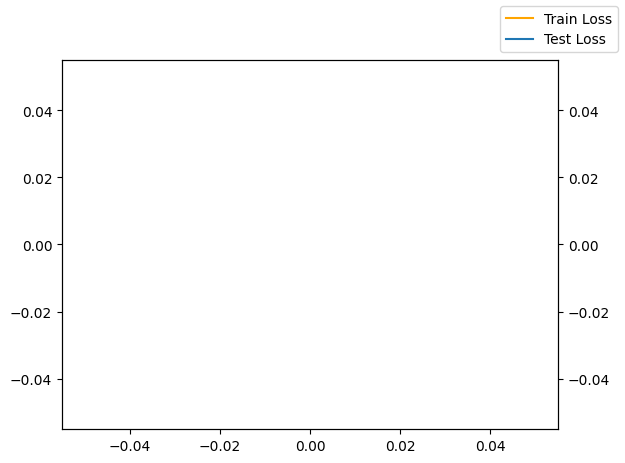

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(train_loss[20:], label = "Train Loss", color = "orange")
ax2.plot(test_loss[20:], label = "Test Loss")
fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")
plt.show()

In [ ]:
sm_net = torch.load("./attention.pth")

              precision    recall  f1-score   support

           0       0.45      0.54      0.49       865
           1       0.59      0.49      0.54      1135

    accuracy                           0.51      2000
   macro avg       0.52      0.52      0.51      2000
weighted avg       0.53      0.51      0.52      2000

              precision    recall  f1-score   support

           0       0.46      0.66      0.54       865
           1       0.61      0.39      0.48      1135

    accuracy                           0.51      2000
   macro avg       0.53      0.53      0.51      2000
weighted avg       0.54      0.51      0.51      2000

              precision    recall  f1-score   support

           0       0.45      0.77      0.57       865
           1       0.62      0.28      0.38      1135

    accuracy                           0.49      2000
   macro avg       0.53      0.53      0.48      2000
weighted avg       0.54      0.49      0.46      2000

              preci

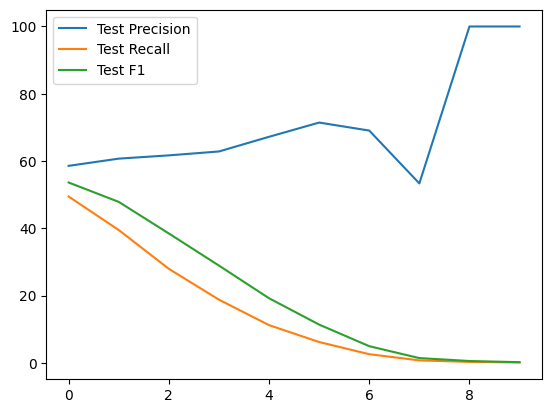

In [ ]:
prs = []
rec = []
f1 = []
loss = []

for i in np.arange(3, 4, 0.1):
    l, p, r, f, _, _, _ = sm_net.evaluate(i)
    prs.append(p)
    rec.append(r)
    f1.append(f)
    loss.append(l)

plt.plot(prs, label = "Test Precision")
plt.plot(rec, label = "Test Recall")
plt.plot(f1, label = "Test F1")

plt.legend()
plt.show()

# **3 (Meta+Text)**

In [ ]:
class SiameseNet2(nn.Module):
    def __init__(self, device=device, channel=84):
        super(SiameseNet2, self).__init__()
        self.encoder_user = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.user_embedding_size, 1024)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1024, channel)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_item = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.item_embedding_size, 256)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(256, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))

        #self.encoder_video = nn.Sequential(OrderedDict([
        #    ('linr1', nn.Linear(train_dataset.video_embedding_size, 1600)),
        #    ('relu1', nn.LeakyReLU()),
        #    ('linr2', nn.Linear(1600, 300)),
        #    ('relu2', nn.LeakyReLU()),
        #]))

        #self.encoder_audio = nn.Sequential(OrderedDict([
        #    ('linr1', nn.Linear(train_dataset.audio_embedding_size, 600)),
        #    ('relu1', nn.LeakyReLU()),
        #    ('linr4', nn.Linear(600, 300)),
        #    ('relu4', nn.LeakyReLU()),
        #]))

        self.encoder_text = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.text_embedding_size, 256)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(256, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_meta = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.meta_embedding_size, 1600)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1600, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.fusion = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, 1, (20, 20), stride=(2, 2))),
            ('relu1', nn.LeakyReLU()),
            ('conv2', nn.Conv2d(1, 1, (5, 50), stride=(1, 1))),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.siamese = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(channel, 200)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(200, 256)),
            ('relu2', nn.LeakyReLU()),
            ('linr3', nn.Linear(256, 100)),
            ('relu3', nn.LeakyReLU()),
        ]))

        self.ffn = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(300, 164)),
            ('actv1', nn.ReLU()),
            ('linr2', nn.Linear(164, 1)),
        ]))

        self.device = device
        self.encoder_user.apply(self.init_weights)
        self.encoder_item.apply(self.init_weights)
        #self.encoder_video.apply(self.init_weights)
        #self.encoder_audio.apply(self.init_weights)
        self.encoder_text.apply(self.init_weights)
        self.encoder_meta.apply(self.init_weights)
        self.siamese.apply(self.init_weights)
        self.ffn.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

    def exp(self, q, k, v):
        z = torch.bmm(q, k.permute(0, 2, 1))
        z = F.normalize(z, p=10, dim=1)
        z = torch.softmax(z, 1)
        z = torch.bmm(z, v)
        return z

    def forward(self, x1, x2):
        # Modality-encoders
        outu = self.encoder_user(x1)
        outr = self.encoder_item(x2[3])
        #outv = torch.split(self.encoder_video(x2[0]), [100, 100, 100], 1)
        #outa = torch.split(self.encoder_audio(x2[1]), [100, 100, 100], 1)
        outt = torch.split(self.encoder_text(x2[2]), 100, 1)
        outm = torch.split(self.encoder_meta(x2[4]), [100, 100, 100], 1)

        # Attention
        q_t = outt[0].unsqueeze(1).repeat(1, ROW, 1)
        k_t = outt[1].unsqueeze(1).repeat(1, ROW, 1)
        v_t = outt[2].unsqueeze(1).repeat(1, ROW, 1)

        #q_a = outa[0].unsqueeze(1).repeat(1, ROW, 1)
        #k_a = outa[1].unsqueeze(1).repeat(1, ROW, 1)
        #v_a = outa[2].unsqueeze(1).repeat(1, ROW, 1)

        #q_v = outv[0].unsqueeze(1).repeat(1, ROW, 1)
        #k_v = outv[1].unsqueeze(1).repeat(1, ROW, 1)
        #v_v = outv[2].unsqueeze(1).repeat(1, ROW, 1)

        q_m = outm[0].unsqueeze(1).repeat(1, ROW, 1)
        k_m = outm[1].unsqueeze(1).repeat(1, ROW, 1)
        v_m = outm[2].unsqueeze(1).repeat(1, ROW, 1)

        # Self-Attention
        st = self.exp(q_t, k_t, v_t)
        sm = self.exp(q_m, k_m, v_m)
        #sa = self.exp(q_a, k_a, v_a)
        #sv = self.exp(q_v, k_v, v_v)

        # Inter-Modal Attention
        itv = self.exp(q_t, k_m, v_t)  # Attention between video and text
        ima = self.exp(q_m, k_t, v_m)  # Attention between meta and audio

        # Forward
        ma = torch.mean(torch.stack([st, ima]), 0)
        mv = torch.mean(torch.stack([sm, itv]), 0)
        sda = sm
        se = torch.mul(ma, mv)
        outi = torch.cat((sda, se), axis=2)
        outi = self.fusion(outi.unsqueeze(1))
        out1 = self.siamese(outu)
        out2 = self.siamese(outi.reshape(BATCH, -1))
        diff = torch.cat((out1, out2, outm[2]), axis=1)
        out = self.ffn(diff)
        return out, out1, out2

    def fit(self, trainloader=trainloader, testloader=testloader, epochs=1):
        self.criterion_rate = weighted_mse_loss
        self.criterion_embd = nn.CosineEmbeddingLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=1e-4)

        train_loss = []
        train_f1 = []
        test_loss = []
        test_f1 = []
        for epoch in range(epochs):
            running_loss = 0.0
            running_loss_1 = 0.0

            for i, data in tqdm(enumerate(trainloader)):
                self.train()
                x1, x2, y = data
                y_flt = y.type(torch.FloatTensor).to(device)
                y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
                self.optimizer.zero_grad()
                reg, outu, outi = self.forward(x1, x2)
                loss_1, loss_ = self.criterion_rate(reg.squeeze(), y_flt)
                loss_2 = self.criterion_embd(outu, outi, y_lng * 2 - 1)
                loss = loss_1 + loss_2
                loss.backward()
                self.optimizer.step()

                running_loss_1 += torch.sqrt(loss_)
                running_loss += loss
            vl, vp, vr, vf, tp, tr, tf = self.evaluate()
            print('Epoch-%d: Loss = %.3f\nTrain RMSE = %.3f||Train Precision = %.3f||Train Recall = %.3f\nTest RMSE = %.3f || Test Precision = %.3f|| Test Recall = %.3f'%
                  (epoch + 1, running_loss / i, running_loss_1 / i,
                   tp, tr, vl, vp, vr))
            train_loss.append((running_loss_1 / i).cpu().detach().numpy())
            test_loss.append(vl.cpu().detach().numpy())
            train_f1.append(tf)
            test_f1.append(vf)
        return train_loss, test_loss, train_f1, test_f1

    def evaluate(self, k=3.5):
        self.eval()
        with torch.no_grad():
            valdata = next(iter(testloader))
            x1, x2, y = valdata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            vl = torch.sqrt(self.criterion_rate(otpt[0].squeeze(), y_flt)[1])
            vp = precision_score(y_lng.cpu(), pred.cpu(), zero_division=0)
            vr = recall_score(y_lng.cpu(), pred.cpu(), zero_division=0)
            vf = f1_score(y_lng.cpu(), pred.cpu(), zero_division=0)
            print(classification_report(y_lng.cpu(), pred.cpu(),
                    target_names=["0", "1"], zero_division=0))

            traindata = next(iter(trainloader))
            x1, x2, y = traindata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            tp = precision_score(y_lng.cpu(), pred.cpu(), zero_division=0)
            tr = recall_score(y_lng.cpu(), pred.cpu(), zero_division=0)
            tf = f1_score(y_lng.cpu(), pred.cpu(), zero_division=0)
        return vl, vp*100, vr*100, vf*100, tp*100, tr*100, tf*100


In [ ]:
sm_net = SiameseNet2()
sm_net.to(device)

SiameseNet2(
  (encoder_user): Sequential(
    (linr1): Linear(in_features=1220, out_features=1024, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1024, out_features=84, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_item): Sequential(
    (linr1): Linear(in_features=943, out_features=256, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=256, out_features=300, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_text): Sequential(
    (linr1): Linear(in_features=384, out_features=256, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=256, out_features=300, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_meta): Sequential(
    (linr1): Linear(in_features=1220, out_features=1600, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1600, out_features=300, bias=True)
    (relu2): L

In [ ]:
train_loss, test_loss, train_f1, test_f1 = sm_net.fit()

40it [00:33,  1.21it/s]


              precision    recall  f1-score   support

           0       0.44      0.93      0.60       865
           1       0.64      0.10      0.17      1135

    accuracy                           0.46      2000
   macro avg       0.54      0.51      0.38      2000
weighted avg       0.55      0.46      0.35      2000

Epoch-1: Loss = 9.147
Train RMSE = 2.262||Train Precision = 59.016||Train Recall = 6.389
Test RMSE = 1.578 || Test Precision = 63.953|| Test Recall = 9.692


In [ ]:
# torch.save(sm_net, "./attention.pth")

In [ ]:
sm_net.evaluate(k=3.5)

              precision    recall  f1-score   support

           0       0.44      0.93      0.60       865
           1       0.64      0.10      0.17      1135

    accuracy                           0.46      2000
   macro avg       0.54      0.51      0.38      2000
weighted avg       0.55      0.46      0.35      2000



(tensor(1.5781, device='cuda:0'),
 63.95348837209303,
 9.691629955947137,
 16.832440703902066,
 60.76923076923077,
 7.149321266968325,
 12.793522267206479)

<ipython-input-42-abf663b56279>:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")


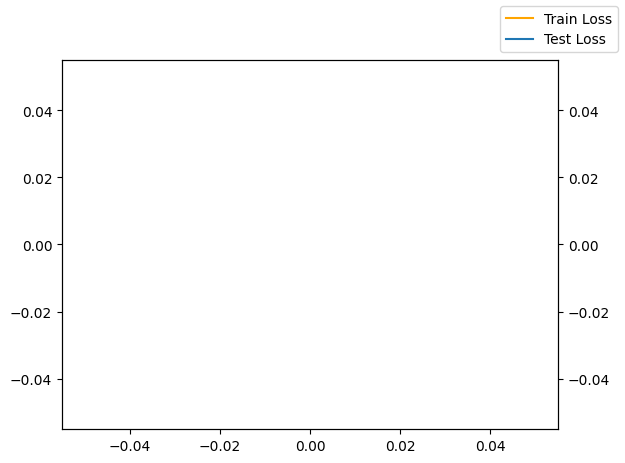

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(train_loss[20:], label = "Train Loss", color = "orange")
ax2.plot(test_loss[20:], label = "Test Loss")
fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")
plt.show()

In [ ]:
# sm_net = torch.load("./attention.pth")

              precision    recall  f1-score   support

           0       0.45      0.47      0.46       865
           1       0.58      0.56      0.57      1135

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.51      2000
weighted avg       0.52      0.52      0.52      2000

              precision    recall  f1-score   support

           0       0.45      0.60      0.51       865
           1       0.59      0.45      0.51      1135

    accuracy                           0.51      2000
   macro avg       0.52      0.52      0.51      2000
weighted avg       0.53      0.51      0.51      2000

              precision    recall  f1-score   support

           0       0.45      0.69      0.54       865
           1       0.60      0.35      0.44      1135

    accuracy                           0.50      2000
   macro avg       0.52      0.52      0.49      2000
weighted avg       0.53      0.50      0.48      2000

              preci

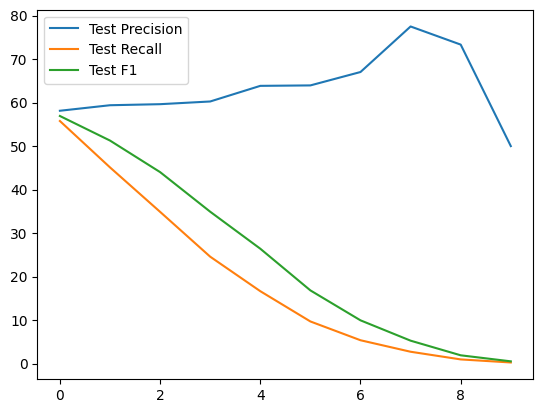

In [ ]:
prs = []
rec = []
f1 = []
loss = []

for i in np.arange(3, 4, 0.1):
    l, p, r, f, _, _, _ = sm_net.evaluate(i)
    prs.append(p)
    rec.append(r)
    f1.append(f)
    loss.append(l)

plt.plot(prs, label = "Test Precision")
plt.plot(rec, label = "Test Recall")
plt.plot(f1, label = "Test F1")

plt.legend()
plt.show()

# **4(Meta + Video)**

In [ ]:
class SiameseNet3(nn.Module):
    def __init__(self, device=device, channel=84):
        super(SiameseNet3, self).__init__()
        self.encoder_user = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.user_embedding_size, 1024)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1024, channel)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_item = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.item_embedding_size, 256)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(256, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_video = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.video_embedding_size, 1600)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1600, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))

        #self.encoder_audio = nn.Sequential(OrderedDict([
        #    ('linr1', nn.Linear(train_dataset.audio_embedding_size, 600)),
        #    ('relu1', nn.LeakyReLU()),
        #    ('linr4', nn.Linear(600, 300)),
        #    ('relu4', nn.LeakyReLU()),
        #]))

        #self.encoder_text = nn.Sequential(OrderedDict([
        #    ('linr1', nn.Linear(train_dataset.text_embedding_size, 256)),
        #    ('relu1', nn.LeakyReLU()),
        #    ('linr2', nn.Linear(256, 300)),
        #    ('relu2', nn.LeakyReLU()),
        #]))

        self.encoder_meta = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.meta_embedding_size, 1600)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1600, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.fusion = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, 1, (20, 20), stride=(2, 2))),
            ('relu1', nn.LeakyReLU()),
            ('conv2', nn.Conv2d(1, 1, (5, 50), stride=(1, 1))),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.siamese = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(channel, 200)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(200, 256)),
            ('relu2', nn.LeakyReLU()),
            ('linr3', nn.Linear(256, 100)),
            ('relu3', nn.LeakyReLU()),
        ]))

        self.ffn = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(300, 164)),
            ('actv1', nn.ReLU()),
            ('linr2', nn.Linear(164, 1)),
        ]))

        self.device = device
        self.encoder_user.apply(self.init_weights)
        self.encoder_item.apply(self.init_weights)
        self.encoder_video.apply(self.init_weights)
        #self.encoder_audio.apply(self.init_weights)
        #self.encoder_text.apply(self.init_weights)
        self.encoder_meta.apply(self.init_weights)
        self.siamese.apply(self.init_weights)
        self.ffn.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

    def exp(self, q, k, v):
        z = torch.bmm(q, k.permute(0, 2, 1))
        z = F.normalize(z, p=10, dim=1)
        z = torch.softmax(z, 1)
        z = torch.bmm(z, v)
        return z

    def forward(self, x1, x2):
        # Modality-encoders
        outu = self.encoder_user(x1)
        outr = self.encoder_item(x2[3])
        outv = torch.split(self.encoder_video(x2[0]), [100, 100, 100], 1)
        #outa = torch.split(self.encoder_audio(x2[1]), [100, 100, 100], 1)
        #outt = torch.split(self.encoder_text(x2[2]), 100, 1)
        outm = torch.split(self.encoder_meta(x2[4]), [100, 100, 100], 1)

        # Attention
        #q_t = outt[0].unsqueeze(1).repeat(1, ROW, 1)
        #k_t = outt[1].unsqueeze(1).repeat(1, ROW, 1)
        #v_t = outt[2].unsqueeze(1).repeat(1, ROW, 1)

        #q_a = outa[0].unsqueeze(1).repeat(1, ROW, 1)
        #k_a = outa[1].unsqueeze(1).repeat(1, ROW, 1)
        #v_a = outa[2].unsqueeze(1).repeat(1, ROW, 1)

        q_v = outv[0].unsqueeze(1).repeat(1, ROW, 1)
        k_v = outv[1].unsqueeze(1).repeat(1, ROW, 1)
        v_v = outv[2].unsqueeze(1).repeat(1, ROW, 1)

        q_m = outm[0].unsqueeze(1).repeat(1, ROW, 1)
        k_m = outm[1].unsqueeze(1).repeat(1, ROW, 1)
        v_m = outm[2].unsqueeze(1).repeat(1, ROW, 1)

        # Self-Attention
        #st = self.exp(q_t, k_t, v_t)
        sm = self.exp(q_m, k_m, v_m)
        #sa = self.exp(q_a, k_a, v_a)
        sv = self.exp(q_v, k_v, v_v)

        # Inter-Modal Attention
        itv = self.exp(q_v, k_m, v_v)  # Attention between video and text
        ima = self.exp(q_m, k_v, v_m)  # Attention between meta and audio

        # Forward
        ma = torch.mean(torch.stack([sv, ima]), 0)
        mv = torch.mean(torch.stack([sm, itv]), 0)
        sda = sm
        se = torch.mul(ma, mv)
        outi = torch.cat((sda, se), axis=2)
        outi = self.fusion(outi.unsqueeze(1))
        out1 = self.siamese(outu)
        out2 = self.siamese(outi.reshape(BATCH, -1))
        diff = torch.cat((out1, out2, outm[2]), axis=1)
        out = self.ffn(diff)
        return out, out1, out2

    def fit(self, trainloader=trainloader, testloader=testloader, epochs=1):
        self.criterion_rate = weighted_mse_loss
        self.criterion_embd = nn.CosineEmbeddingLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=1e-4)

        train_loss = []
        train_f1 = []
        test_loss = []
        test_f1 = []
        for epoch in range(epochs):
            running_loss = 0.0
            running_loss_1 = 0.0

            for i, data in tqdm(enumerate(trainloader)):
                self.train()
                x1, x2, y = data
                y_flt = y.type(torch.FloatTensor).to(device)
                y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
                self.optimizer.zero_grad()
                reg, outu, outi = self.forward(x1, x2)
                loss_1, loss_ = self.criterion_rate(reg.squeeze(), y_flt)
                loss_2 = self.criterion_embd(outu, outi, y_lng * 2 - 1)
                loss = loss_1 + loss_2
                loss.backward()
                self.optimizer.step()

                running_loss_1 += torch.sqrt(loss_)
                running_loss += loss
            vl, vp, vr, vf, tp, tr, tf = self.evaluate()
            print('Epoch-%d: Loss = %.3f\nTrain RMSE = %.3f||Train Precision = %.3f||Train Recall = %.3f\nTest RMSE = %.3f || Test Precision = %.3f|| Test Recall = %.3f'%
                  (epoch + 1, running_loss / i, running_loss_1 / i,
                   tp, tr, vl, vp, vr))
            train_loss.append((running_loss_1 / i).cpu().detach().numpy())
            test_loss.append(vl.cpu().detach().numpy())
            train_f1.append(tf)
            test_f1.append(vf)
        return train_loss, test_loss, train_f1, test_f1

    def evaluate(self, k=3.5):
        self.eval()
        with torch.no_grad():
            valdata = next(iter(testloader))
            x1, x2, y = valdata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            vl = torch.sqrt(self.criterion_rate(otpt[0].squeeze(), y_flt)[1])
            vp = precision_score(y_lng.cpu(), pred.cpu(), zero_division=0)
            vr = recall_score(y_lng.cpu(), pred.cpu(), zero_division=0)
            vf = f1_score(y_lng.cpu(), pred.cpu(), zero_division=0)
            print(classification_report(y_lng.cpu(), pred.cpu(),
                    target_names=["0", "1"], zero_division=0))

            traindata = next(iter(trainloader))
            x1, x2, y = traindata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            tp = precision_score(y_lng.cpu(), pred.cpu(), zero_division=0)
            tr = recall_score(y_lng.cpu(), pred.cpu(), zero_division=0)
            tf = f1_score(y_lng.cpu(), pred.cpu(), zero_division=0)
        return vl, vp*100, vr*100, vf*100, tp*100, tr*100, tf*100


In [ ]:
sm_net = SiameseNet3()
sm_net.to(device)

SiameseNet3(
  (encoder_user): Sequential(
    (linr1): Linear(in_features=1220, out_features=1024, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1024, out_features=84, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_item): Sequential(
    (linr1): Linear(in_features=943, out_features=256, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=256, out_features=300, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_video): Sequential(
    (linr1): Linear(in_features=1024, out_features=1600, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1600, out_features=300, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_meta): Sequential(
    (linr1): Linear(in_features=1220, out_features=1600, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1600, out_features=300, bias=True)
    (relu2

In [ ]:
train_loss, test_loss, train_f1, test_f1 = sm_net.fit()

40it [00:32,  1.22it/s]


              precision    recall  f1-score   support

           0       0.43      0.97      0.60       865
           1       0.61      0.03      0.07      1135

    accuracy                           0.44      2000
   macro avg       0.52      0.50      0.33      2000
weighted avg       0.53      0.44      0.30      2000

Epoch-1: Loss = 8.840
Train RMSE = 2.176||Train Precision = 76.190||Train Recall = 1.504
Test RMSE = 1.563 || Test Precision = 60.938|| Test Recall = 3.436


In [ ]:
sm_net.evaluate(k=3.5)

              precision    recall  f1-score   support

           0       0.43      0.97      0.60       865
           1       0.61      0.03      0.07      1135

    accuracy                           0.44      2000
   macro avg       0.52      0.50      0.33      2000
weighted avg       0.53      0.44      0.30      2000



(tensor(1.5626, device='cuda:0'),
 60.9375,
 3.4361233480176208,
 6.505421184320266,
 56.41025641025641,
 2.033271719038817,
 3.9250669045495097)

<ipython-input-49-abf663b56279>:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")


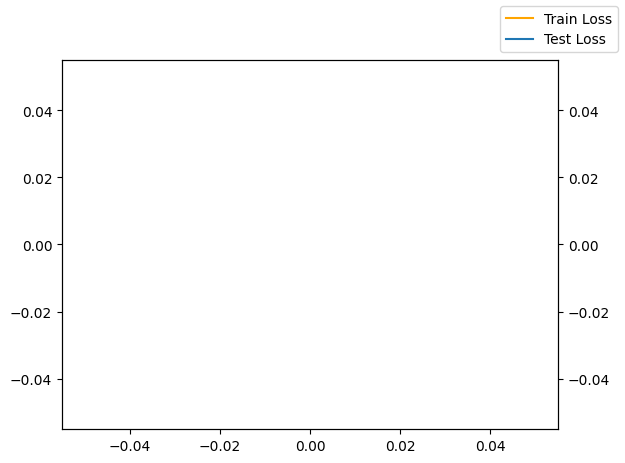

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(train_loss[20:], label = "Train Loss", color = "orange")
ax2.plot(test_loss[20:], label = "Test Loss")
fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")
plt.show()

              precision    recall  f1-score   support

           0       0.43      0.57      0.49       865
           1       0.56      0.42      0.48      1135

    accuracy                           0.49      2000
   macro avg       0.50      0.50      0.49      2000
weighted avg       0.51      0.49      0.48      2000

              precision    recall  f1-score   support

           0       0.43      0.68      0.53       865
           1       0.56      0.30      0.39      1135

    accuracy                           0.47      2000
   macro avg       0.49      0.49      0.46      2000
weighted avg       0.50      0.47      0.45      2000

              precision    recall  f1-score   support

           0       0.43      0.80      0.56       865
           1       0.58      0.20      0.30      1135

    accuracy                           0.46      2000
   macro avg       0.50      0.50      0.43      2000
weighted avg       0.51      0.46      0.41      2000

              preci

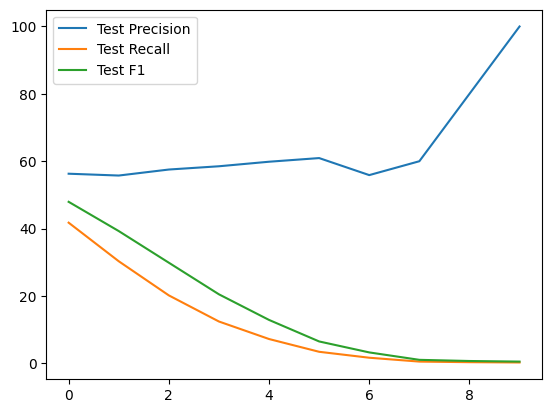

In [ ]:
prs = []
rec = []
f1 = []
loss = []

for i in np.arange(3, 4, 0.1):
    l, p, r, f, _, _, _ = sm_net.evaluate(i)
    prs.append(p)
    rec.append(r)
    f1.append(f)
    loss.append(l)

plt.plot(prs, label = "Test Precision")
plt.plot(rec, label = "Test Recall")
plt.plot(f1, label = "Test F1")

plt.legend()
plt.show()

# **(Text + Audio)**

In [ ]:
class SiameseNet4(nn.Module):
    def __init__(self, device = device, channel = 84):
        super(SiameseNet4, self).__init__()
        self.encoder_user = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.user_embedding_size, 1024)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1024, channel)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_item = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.item_embedding_size, 256)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(256, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))

        #self.encoder_video = nn.Sequential(OrderedDict([
            #('linr1', nn.Linear(train_dataset.video_embedding_size, 1600)),
            #('relu1', nn.LeakyReLU()),
            #('linr2', nn.Linear(1600, 300)),
            #('relu2', nn.LeakyReLU()),
#             ('linr3', nn.Linear(1000, 500)),
#             ('relu3', nn.LeakyReLU()),
# #             ('norm2', nn.BatchNorm1d(500)),
#             ('linr4', nn.Linear(500, 300)),
#             ('relu4', nn.LeakyReLU()),
        #]))

        self.encoder_audio = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.audio_embedding_size, 600)),
            ('relu1', nn.LeakyReLU()),
            ('linr4', nn.Linear(600, 300)),
            ('relu4', nn.LeakyReLU()),
        ]))

        self.encoder_text = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.text_embedding_size, 256)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(256, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))

        #self.encoder_meta = nn.Sequential(OrderedDict([
         #   ('linr1', nn.Linear(train_dataset.meta_embedding_size, 1600)),
          #  ('relu1', nn.LeakyReLU()),
#             ('norm1', nn.BatchNorm1d(1600)),
          #  ('linr2', nn.Linear(1600, 300)),
           # ('relu2', nn.LeakyReLU()),
#             ('linr3', nn.Linear(1000, 500)),
#             ('relu3', nn.LeakyReLU()),
#             ('linr4', nn.Linear(500, 300)),
#             ('relu4', nn.LeakyReLU()),
        #]))

        self.fusion = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, 1, (20, 20), stride=(2, 2))),
            ('relu1', nn.LeakyReLU()),
            ('conv2', nn.Conv2d(1, 1, (5, 50), stride=(1, 1))),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.siamese = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(channel, 200)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(200, 256)),
            ('relu2', nn.LeakyReLU()),
            ('linr3', nn.Linear(256, 100)),
            ('relu3', nn.LeakyReLU()),
        ]))

        self.ffn = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(300, 164)),
            ('actv1', nn.ReLU()),
            ('linr2', nn.Linear(164, 1)),
#             ('actv2', nn.ReLU()),
#             ('linr3', nn.Linear(50, 1)),
        ]))

        self.device = device
        self.encoder_user.apply(self.init_weights)
        self.encoder_item.apply(self.init_weights)
        #self.encoder_video.apply(self.init_weights)
        self.encoder_audio.apply(self.init_weights)
        self.encoder_text.apply(self.init_weights)
        #self.encoder_meta.apply(self.init_weights)
        self.siamese.apply(self.init_weights)
        self.ffn.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

    def exp(self, q, k, v):
        z = torch.bmm(q, k.permute(0, 2, 1))
        z = F.normalize(z, p = 10, dim = 1)
        z = torch.softmax(z, 1)
        z = torch.bmm(z, v)
        return(z)

    def forward(self, x1, x2):
        # Modality-encoders
        outu = self.encoder_user(x1)
        outr = self.encoder_item(x2[3])
        #outv = torch.split(self.encoder_video(x2[0]), [100, 100, 100], 1)
        outa = torch.split(self.encoder_audio(x2[1]), [100, 100, 100], 1)
        outt = torch.split(self.encoder_text(x2[2]), 100, 1)
       # outm = torch.split(self.encoder_meta(x2[4]), [100, 100, 100], 1)

        # Attention
        q_t = outt[0].unsqueeze(1).repeat(1, ROW, 1)
        k_t = outt[1].unsqueeze(1).repeat(1, ROW, 1)
        v_t = outt[2].unsqueeze(1).repeat(1, ROW, 1)

        q_a = outa[0].unsqueeze(1).repeat(1, ROW, 1)
        k_a = outa[1].unsqueeze(1).repeat(1, ROW, 1)
        v_a = outa[2].unsqueeze(1).repeat(1, ROW, 1)

        #q_v = outv[0].unsqueeze(1).repeat(1, ROW, 1)
        #k_v = outv[1].unsqueeze(1).repeat(1, ROW, 1)
        #v_v = outv[2].unsqueeze(1).repeat(1, ROW, 1)

        #q_m = outm[0].unsqueeze(1).repeat(1, ROW, 1)
        #k_m = outm[1].unsqueeze(1).repeat(1, ROW, 1)
        #v_m = outm[2].unsqueeze(1).repeat(1, ROW, 1)

        # Self-Attention
        st = self.exp(q_t, k_t, v_t)
        #sm = self.exp(q_m, k_m, v_m)
        sa = self.exp(q_a, k_a, v_a)
        #sv = self.exp(q_v, k_v, v_v)

        # Inter-Modal Attention
        ita = self.exp(q_a, k_t, v_a)
        #imv = self.exp(q_v, k_m, v_v)
        itm = self.exp(q_t, k_a, v_t)

        # Forward
        ma = torch.mean(torch.stack([sa, ita]), 0)
        mv = torch.mean(torch.stack([st, itm]), 0)
        sda = itm
        se = torch.mul(ma, mv)
        outi = torch.cat((sda, se), axis = 2)#.reshape(-1, ROW * 1200)
        outi = self.fusion(outi.unsqueeze(1))
        out1 = self.siamese(outu)
        out2 = self.siamese(outi.reshape(BATCH, -1))
        diff = torch.cat((out1, out2, outt[2]), axis=1)
        out = self.ffn(diff)
        return(out, out1, out2)

    def fit(self, trainloader = trainloader,
            testloader = testloader, epochs = 1):
        self.criterion_rate = weighted_mse_loss
        self.criterion_embd = nn.CosineEmbeddingLoss()
        self.optimizer = optim.Adam(self.parameters(), lr = 1e-4)

        train_loss = []
        train_f1 = []
        test_loss = []
        test_f1 = []
        for epoch in range(epochs):
            running_loss = 0.0
            running_loss_1 = 0.0

            for i, data in tqdm(enumerate(trainloader)):
                self.train()
                x1, x2, y = data
                y_flt = y.type(torch.FloatTensor).to(device)
                y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
                self.optimizer.zero_grad()
                reg, outu, outi = self.forward(x1, x2)
                loss_1, loss_ = self.criterion_rate(reg.squeeze(), y_flt)
                loss_2 = self.criterion_embd(outu, outi, y_lng * 2 - 1)
                loss = loss_1 + loss_2
                loss.backward()
                self.optimizer.step()

                running_loss_1 += torch.sqrt(loss_)
                running_loss += loss
            vl, vp, vr, vf, tp, tr, tf = self.evaluate()
            print('Epoch-%d: Loss = %.3f\nTrain RMSE = %.3f||Train Precision = %.3f||Train Recall = %.3f\nTest RMSE = %.3f || Test Precision = %.3f|| Test Recall = %.3f'%
                  (epoch + 1, running_loss / i, running_loss_1 / i,
                   tp, tr, vl, vp, vr))
            train_loss.append((running_loss_1 / i).cpu().detach().numpy())
            test_loss.append(vl.cpu().detach().numpy())
            train_f1.append(tf)
            test_f1.append(vf)
        return(train_loss, test_loss, train_f1, test_f1)

    def evaluate(self, k = 3.5):
        self.eval()
        with torch.no_grad():
            valdata = next(iter(testloader))
            x1, x2, y = valdata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            vl = torch.sqrt(self.criterion_rate(otpt[0].squeeze(), y_flt)[1])
            vp = precision_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            vr = recall_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            vf = f1_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            print(classification_report(y_lng.cpu(), pred.cpu(),
                    target_names = ["0", "1"], zero_division = 0))

            traindata = next(iter(trainloader))
            x1, x2, y = traindata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            tp = precision_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            tr = recall_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            tf = f1_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
        return(vl, vp*100, vr*100, vf*100, tp*100, tr*100, tf*100)

In [ ]:
sm_net = SiameseNet4()
sm_net.to(device)

SiameseNet4(
  (encoder_user): Sequential(
    (linr1): Linear(in_features=1220, out_features=1024, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1024, out_features=84, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_item): Sequential(
    (linr1): Linear(in_features=943, out_features=256, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=256, out_features=300, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_audio): Sequential(
    (linr1): Linear(in_features=1024, out_features=600, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr4): Linear(in_features=600, out_features=300, bias=True)
    (relu4): LeakyReLU(negative_slope=0.01)
  )
  (encoder_text): Sequential(
    (linr1): Linear(in_features=384, out_features=256, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=256, out_features=300, bias=True)
    (relu2): Le

In [ ]:
train_loss, test_loss, train_f1, test_f1 = sm_net.fit()

40it [00:46,  1.15s/it]


              precision    recall  f1-score   support

           0       0.44      0.89      0.59       865
           1       0.60      0.12      0.20      1135

    accuracy                           0.46      2000
   macro avg       0.52      0.51      0.39      2000
weighted avg       0.53      0.46      0.37      2000

Epoch-1: Loss = 8.653
Train RMSE = 2.145||Train Precision = 60.294||Train Recall = 11.182
Test RMSE = 1.467 || Test Precision = 59.912|| Test Recall = 11.982


40it [00:32,  1.24it/s]


              precision    recall  f1-score   support

           0       0.43      0.92      0.58       865
           1       0.49      0.06      0.10      1135

    accuracy                           0.43      2000
   macro avg       0.46      0.49      0.34      2000
weighted avg       0.46      0.43      0.31      2000

Epoch-2: Loss = 4.117
Train RMSE = 1.340||Train Precision = 61.765||Train Recall = 1.867
Test RMSE = 1.439 || Test Precision = 48.889|| Test Recall = 5.815


40it [00:31,  1.27it/s]


              precision    recall  f1-score   support

           0       0.43      0.90      0.58       865
           1       0.54      0.09      0.15      1135

    accuracy                           0.44      2000
   macro avg       0.49      0.50      0.37      2000
weighted avg       0.49      0.44      0.34      2000

Epoch-3: Loss = 3.918
Train RMSE = 1.284||Train Precision = 58.824||Train Recall = 3.546
Test RMSE = 1.392 || Test Precision = 54.301|| Test Recall = 8.899


40it [00:32,  1.23it/s]


              precision    recall  f1-score   support

           0       0.44      0.89      0.59       865
           1       0.59      0.12      0.20      1135

    accuracy                           0.45      2000
   macro avg       0.52      0.51      0.39      2000
weighted avg       0.53      0.45      0.37      2000

Epoch-4: Loss = 3.761
Train RMSE = 1.248||Train Precision = 70.796||Train Recall = 7.098
Test RMSE = 1.373 || Test Precision = 59.402|| Test Recall = 12.247


40it [00:32,  1.22it/s]


              precision    recall  f1-score   support

           0       0.45      0.79      0.57       865
           1       0.61      0.25      0.35      1135

    accuracy                           0.48      2000
   macro avg       0.53      0.52      0.46      2000
weighted avg       0.54      0.48      0.45      2000

Epoch-5: Loss = 3.597
Train RMSE = 1.219||Train Precision = 76.316||Train Recall = 15.398
Test RMSE = 1.348 || Test Precision = 61.050|| Test Recall = 24.581


40it [00:32,  1.23it/s]


              precision    recall  f1-score   support

           0       0.45      0.78      0.57       865
           1       0.62      0.27      0.38      1135

    accuracy                           0.49      2000
   macro avg       0.53      0.53      0.47      2000
weighted avg       0.55      0.49      0.46      2000

Epoch-6: Loss = 3.416
Train RMSE = 1.184||Train Precision = 79.381||Train Recall = 20.867
Test RMSE = 1.354 || Test Precision = 61.876|| Test Recall = 27.313


40it [00:32,  1.25it/s]


              precision    recall  f1-score   support

           0       0.46      0.75      0.57       865
           1       0.63      0.33      0.44      1135

    accuracy                           0.51      2000
   macro avg       0.55      0.54      0.50      2000
weighted avg       0.56      0.51      0.49      2000

Epoch-7: Loss = 3.250
Train RMSE = 1.155||Train Precision = 77.500||Train Recall = 30.528
Test RMSE = 1.331 || Test Precision = 63.211|| Test Recall = 33.304


40it [00:32,  1.23it/s]


              precision    recall  f1-score   support

           0       0.46      0.77      0.58       865
           1       0.64      0.32      0.43      1135

    accuracy                           0.51      2000
   macro avg       0.55      0.54      0.50      2000
weighted avg       0.56      0.51      0.49      2000

Epoch-8: Loss = 3.112
Train RMSE = 1.130||Train Precision = 73.605||Train Recall = 31.125
Test RMSE = 1.331 || Test Precision = 64.311|| Test Recall = 32.070


40it [00:32,  1.23it/s]


              precision    recall  f1-score   support

           0       0.47      0.73      0.57       865
           1       0.65      0.37      0.47      1135

    accuracy                           0.53      2000
   macro avg       0.56      0.55      0.52      2000
weighted avg       0.57      0.53      0.51      2000

Epoch-9: Loss = 3.026
Train RMSE = 1.117||Train Precision = 77.453||Train Recall = 40.798
Test RMSE = 1.299 || Test Precision = 64.561|| Test Recall = 36.916


40it [00:31,  1.27it/s]


              precision    recall  f1-score   support

           0       0.47      0.75      0.58       865
           1       0.65      0.35      0.46      1135

    accuracy                           0.52      2000
   macro avg       0.56      0.55      0.52      2000
weighted avg       0.57      0.52      0.51      2000

Epoch-10: Loss = 2.947
Train RMSE = 1.104||Train Precision = 73.868||Train Recall = 39.006
Test RMSE = 1.282 || Test Precision = 64.887|| Test Recall = 35.330


40it [00:31,  1.26it/s]


              precision    recall  f1-score   support

           0       0.49      0.69      0.57       865
           1       0.65      0.44      0.53      1135

    accuracy                           0.55      2000
   macro avg       0.57      0.57      0.55      2000
weighted avg       0.58      0.55      0.55      2000

Epoch-11: Loss = 2.903
Train RMSE = 1.099||Train Precision = 74.835||Train Recall = 51.683
Test RMSE = 1.245 || Test Precision = 65.455|| Test Recall = 44.405


40it [00:32,  1.23it/s]


              precision    recall  f1-score   support

           0       0.49      0.70      0.58       865
           1       0.67      0.45      0.54      1135

    accuracy                           0.56      2000
   macro avg       0.58      0.58      0.56      2000
weighted avg       0.59      0.56      0.55      2000

Epoch-12: Loss = 2.862
Train RMSE = 1.090||Train Precision = 75.066||Train Recall = 51.737
Test RMSE = 1.235 || Test Precision = 66.536|| Test Recall = 44.846


40it [00:31,  1.25it/s]


              precision    recall  f1-score   support

           0       0.47      0.83      0.60       865
           1       0.69      0.29      0.41      1135

    accuracy                           0.53      2000
   macro avg       0.58      0.56      0.51      2000
weighted avg       0.60      0.53      0.49      2000

Epoch-13: Loss = 2.843
Train RMSE = 1.087||Train Precision = 78.755||Train Recall = 39.269
Test RMSE = 1.281 || Test Precision = 69.311|| Test Recall = 29.251


40it [00:31,  1.27it/s]


              precision    recall  f1-score   support

           0       0.48      0.80      0.60       865
           1       0.68      0.33      0.45      1135

    accuracy                           0.53      2000
   macro avg       0.58      0.57      0.52      2000
weighted avg       0.59      0.53      0.51      2000

Epoch-14: Loss = 2.781
Train RMSE = 1.077||Train Precision = 79.146||Train Recall = 43.036
Test RMSE = 1.267 || Test Precision = 68.345|| Test Recall = 33.480


40it [00:31,  1.25it/s]


              precision    recall  f1-score   support

           0       0.50      0.76      0.60       865
           1       0.70      0.42      0.53      1135

    accuracy                           0.57      2000
   macro avg       0.60      0.59      0.57      2000
weighted avg       0.61      0.57      0.56      2000

Epoch-15: Loss = 2.751
Train RMSE = 1.073||Train Precision = 78.120||Train Recall = 47.247
Test RMSE = 1.229 || Test Precision = 69.710|| Test Recall = 42.379


40it [00:31,  1.27it/s]


              precision    recall  f1-score   support

           0       0.51      0.75      0.61       865
           1       0.70      0.45      0.55      1135

    accuracy                           0.58      2000
   macro avg       0.61      0.60      0.58      2000
weighted avg       0.62      0.58      0.57      2000

Epoch-16: Loss = 2.722
Train RMSE = 1.067||Train Precision = 78.125||Train Recall = 54.490
Test RMSE = 1.216 || Test Precision = 70.123|| Test Recall = 45.286


40it [00:31,  1.28it/s]


              precision    recall  f1-score   support

           0       0.51      0.77      0.61       865
           1       0.71      0.45      0.55      1135

    accuracy                           0.59      2000
   macro avg       0.61      0.61      0.58      2000
weighted avg       0.63      0.59      0.58      2000

Epoch-17: Loss = 2.693
Train RMSE = 1.064||Train Precision = 80.212||Train Recall = 54.562
Test RMSE = 1.218 || Test Precision = 71.489|| Test Recall = 44.846


40it [00:32,  1.25it/s]


              precision    recall  f1-score   support

           0       0.50      0.80      0.61       865
           1       0.72      0.38      0.50      1135

    accuracy                           0.56      2000
   macro avg       0.61      0.59      0.55      2000
weighted avg       0.62      0.56      0.55      2000

Epoch-18: Loss = 2.680
Train RMSE = 1.061||Train Precision = 78.219||Train Recall = 44.485
Test RMSE = 1.246 || Test Precision = 71.547|| Test Recall = 37.885


40it [00:31,  1.25it/s]


              precision    recall  f1-score   support

           0       0.52      0.77      0.62       865
           1       0.72      0.45      0.55      1135

    accuracy                           0.59      2000
   macro avg       0.62      0.61      0.59      2000
weighted avg       0.63      0.59      0.58      2000

Epoch-19: Loss = 2.674
Train RMSE = 1.062||Train Precision = 79.539||Train Recall = 48.850
Test RMSE = 1.218 || Test Precision = 72.222|| Test Recall = 44.670


40it [00:31,  1.26it/s]


              precision    recall  f1-score   support

           0       0.52      0.75      0.61       865
           1       0.71      0.47      0.57      1135

    accuracy                           0.59      2000
   macro avg       0.62      0.61      0.59      2000
weighted avg       0.63      0.59      0.59      2000

Epoch-20: Loss = 2.648
Train RMSE = 1.060||Train Precision = 76.516||Train Recall = 53.568
Test RMSE = 1.208 || Test Precision = 71.108|| Test Recall = 47.489


<ipython-input-78-abf663b56279>:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")


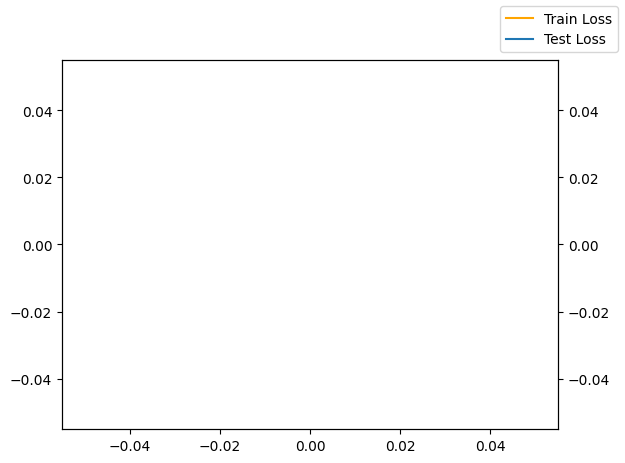

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(train_loss[20:], label = "Train Loss", color = "orange")
ax2.plot(test_loss[20:], label = "Test Loss")
fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")
plt.show()

              precision    recall  f1-score   support

           0       0.62      0.50      0.55       865
           1       0.67      0.77      0.71      1135

    accuracy                           0.65      2000
   macro avg       0.64      0.63      0.63      2000
weighted avg       0.65      0.65      0.64      2000

              precision    recall  f1-score   support

           0       0.60      0.55      0.58       865
           1       0.68      0.72      0.70      1135

    accuracy                           0.65      2000
   macro avg       0.64      0.64      0.64      2000
weighted avg       0.64      0.65      0.64      2000

              precision    recall  f1-score   support

           0       0.58      0.60      0.59       865
           1       0.69      0.66      0.67      1135

    accuracy                           0.64      2000
   macro avg       0.63      0.63      0.63      2000
weighted avg       0.64      0.64      0.64      2000

              preci

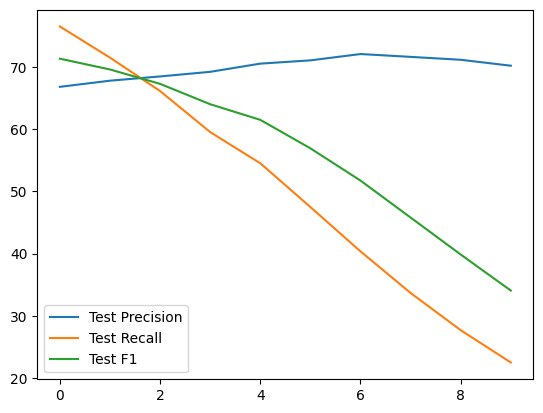

In [ ]:
prs = []
rec = []
f1 = []
loss = []

for i in np.arange(3, 4, 0.1):
    l, p, r, f, _, _, _ = sm_net.evaluate(i)
    prs.append(p)
    rec.append(r)
    f1.append(f)
    loss.append(l)

plt.plot(prs, label = "Test Precision")
plt.plot(rec, label = "Test Recall")
plt.plot(f1, label = "Test F1")

plt.legend()
plt.show()

# **(Text + Video)**

In [ ]:
class SiameseNet5(nn.Module):
    def __init__(self, device = device, channel = 84):
        super(SiameseNet5, self).__init__()
        self.encoder_user = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.user_embedding_size, 1024)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1024, channel)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_item = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.item_embedding_size, 256)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(256, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_video = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.video_embedding_size, 1600)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1600, 300)),
            ('relu2', nn.LeakyReLU()),
#             ('linr3', nn.Linear(1000, 500)),
#             ('relu3', nn.LeakyReLU()),
# #             ('norm2', nn.BatchNorm1d(500)),
#             ('linr4', nn.Linear(500, 300)),
#             ('relu4', nn.LeakyReLU()),
        ]))

        #self.encoder_audio = nn.Sequential(OrderedDict([
        #    ('linr1', nn.Linear(train_dataset.audio_embedding_size, 600)),
        #    ('relu1', nn.LeakyReLU()),
        #    ('linr4', nn.Linear(600, 300)),
        #    ('relu4', nn.LeakyReLU()),
        #]))

        self.encoder_text = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.text_embedding_size, 256)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(256, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))

        #self.encoder_meta = nn.Sequential(OrderedDict([
         #   ('linr1', nn.Linear(train_dataset.meta_embedding_size, 1600)),
         #   ('relu1', nn.LeakyReLU()),
#             ('norm1', nn.BatchNorm1d(1600)),
         #   ('linr2', nn.Linear(1600, 300)),
         #   ('relu2', nn.LeakyReLU()),
#             ('linr3', nn.Linear(1000, 500)),
#             ('relu3', nn.LeakyReLU()),
#             ('linr4', nn.Linear(500, 300)),
#             ('relu4', nn.LeakyReLU()),
        #]))

        self.fusion = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, 1, (20, 20), stride=(2, 2))),
            ('relu1', nn.LeakyReLU()),
            ('conv2', nn.Conv2d(1, 1, (5, 50), stride=(1, 1))),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.siamese = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(channel, 200)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(200, 256)),
            ('relu2', nn.LeakyReLU()),
            ('linr3', nn.Linear(256, 100)),
            ('relu3', nn.LeakyReLU()),
        ]))

        self.ffn = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(300, 164)),
            ('actv1', nn.ReLU()),
            ('linr2', nn.Linear(164, 1)),
#             ('actv2', nn.ReLU()),
#             ('linr3', nn.Linear(50, 1)),
        ]))

        self.device = device
        self.encoder_user.apply(self.init_weights)
        self.encoder_item.apply(self.init_weights)
        self.encoder_video.apply(self.init_weights)
        #self.encoder_audio.apply(self.init_weights)
        self.encoder_text.apply(self.init_weights)
        #self.encoder_meta.apply(self.init_weights)
        self.siamese.apply(self.init_weights)
        self.ffn.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

    def exp(self, q, k, v):
        z = torch.bmm(q, k.permute(0, 2, 1))
        z = F.normalize(z, p = 10, dim = 1)
        z = torch.softmax(z, 1)
        z = torch.bmm(z, v)
        return(z)

    def forward(self, x1, x2):
        # Modality-encoders
        outu = self.encoder_user(x1)
        outr = self.encoder_item(x2[3])
        outv = torch.split(self.encoder_video(x2[0]), [100, 100, 100], 1)
        #outa = torch.split(self.encoder_audio(x2[1]), [100, 100, 100], 1)
        outt = torch.split(self.encoder_text(x2[2]), 100, 1)
        #outm = torch.split(self.encoder_meta(x2[4]), [100, 100, 100], 1)

        # Attention
        q_t = outt[0].unsqueeze(1).repeat(1, ROW, 1)
        k_t = outt[1].unsqueeze(1).repeat(1, ROW, 1)
        v_t = outt[2].unsqueeze(1).repeat(1, ROW, 1)

        #q_a = outa[0].unsqueeze(1).repeat(1, ROW, 1)
        #k_a = outa[1].unsqueeze(1).repeat(1, ROW, 1)
        #v_a = outa[2].unsqueeze(1).repeat(1, ROW, 1)

        q_v = outv[0].unsqueeze(1).repeat(1, ROW, 1)
        k_v = outv[1].unsqueeze(1).repeat(1, ROW, 1)
        v_v = outv[2].unsqueeze(1).repeat(1, ROW, 1)

        #q_m = outm[0].unsqueeze(1).repeat(1, ROW, 1)
        #k_m = outm[1].unsqueeze(1).repeat(1, ROW, 1)
        #v_m = outm[2].unsqueeze(1).repeat(1, ROW, 1)

        # Self-Attention
        st = self.exp(q_t, k_t, v_t)
        #sm = self.exp(q_m, k_m, v_m)
        #sa = self.exp(q_a, k_a, v_a)
        sv = self.exp(q_v, k_v, v_v)

        # Inter-Modal Attention
        #ita = self.exp(q_a, k_t, v_a)
        imv = self.exp(q_v, k_t, v_v)
        #itm = self.exp(q_m, k_t, v_m)

        # Forward
        ma = torch.mean(torch.stack([st, imv]), 0)
        mv = torch.mean(torch.stack([sv, imv]), 0)
        sda = imv
        se = torch.mul(ma, mv)
        outi = torch.cat((sda, se), axis = 2)#.reshape(-1, ROW * 1200)
        outi = self.fusion(outi.unsqueeze(1))
        out1 = self.siamese(outu)
        out2 = self.siamese(outi.reshape(BATCH, -1))
        diff = torch.cat((out1, out2, outv[2]), axis=1)
        out = self.ffn(diff)
        return(out, out1, out2)

    def fit(self, trainloader = trainloader,
            testloader = testloader, epochs = 1):
        self.criterion_rate = weighted_mse_loss
        self.criterion_embd = nn.CosineEmbeddingLoss()
        self.optimizer = optim.Adam(self.parameters(), lr = 1e-4)

        train_loss = []
        train_f1 = []
        test_loss = []
        test_f1 = []
        for epoch in range(epochs):
            running_loss = 0.0
            running_loss_1 = 0.0

            for i, data in tqdm(enumerate(trainloader)):
                self.train()
                x1, x2, y = data
                y_flt = y.type(torch.FloatTensor).to(device)
                y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
                self.optimizer.zero_grad()
                reg, outu, outi = self.forward(x1, x2)
                loss_1, loss_ = self.criterion_rate(reg.squeeze(), y_flt)
                loss_2 = self.criterion_embd(outu, outi, y_lng * 2 - 1)
                loss = loss_1 + loss_2
                loss.backward()
                self.optimizer.step()

                running_loss_1 += torch.sqrt(loss_)
                running_loss += loss
            vl, vp, vr, vf, tp, tr, tf = self.evaluate()
            print('Epoch-%d: Loss = %.3f\nTrain RMSE = %.3f||Train Precision = %.3f||Train Recall = %.3f\nTest RMSE = %.3f || Test Precision = %.3f|| Test Recall = %.3f'%
                  (epoch + 1, running_loss / i, running_loss_1 / i,
                   tp, tr, vl, vp, vr))
            train_loss.append((running_loss_1 / i).cpu().detach().numpy())
            test_loss.append(vl.cpu().detach().numpy())
            train_f1.append(tf)
            test_f1.append(vf)
        return(train_loss, test_loss, train_f1, test_f1)

    def evaluate(self, k = 3.5):
        self.eval()
        with torch.no_grad():
            valdata = next(iter(testloader))
            x1, x2, y = valdata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            vl = torch.sqrt(self.criterion_rate(otpt[0].squeeze(), y_flt)[1])
            vp = precision_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            vr = recall_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            vf = f1_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            print(classification_report(y_lng.cpu(), pred.cpu(),
                    target_names = ["0", "1"], zero_division = 0))

            traindata = next(iter(trainloader))
            x1, x2, y = traindata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            tp = precision_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            tr = recall_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            tf = f1_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
        return(vl, vp*100, vr*100, vf*100, tp*100, tr*100, tf*100)

In [ ]:
sm_net = SiameseNet5()
sm_net.to(device)

SiameseNet5(
  (encoder_user): Sequential(
    (linr1): Linear(in_features=1220, out_features=1024, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1024, out_features=84, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_item): Sequential(
    (linr1): Linear(in_features=943, out_features=256, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=256, out_features=300, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_video): Sequential(
    (linr1): Linear(in_features=1024, out_features=1600, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1600, out_features=300, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_text): Sequential(
    (linr1): Linear(in_features=384, out_features=256, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=256, out_features=300, bias=True)
    (relu2): 

In [ ]:
train_loss, test_loss, train_f1, test_f1 = sm_net.fit()

40it [03:10,  4.76s/it]


              precision    recall  f1-score   support

           0       0.43      0.96      0.59       865
           1       0.30      0.01      0.02      1135

    accuracy                           0.42      2000
   macro avg       0.37      0.49      0.31      2000
weighted avg       0.36      0.42      0.27      2000

Epoch-1: Loss = 7.931
Train RMSE = 2.024||Train Precision = 85.714||Train Recall = 0.530
Test RMSE = 1.539 || Test Precision = 30.435|| Test Recall = 1.233


40it [03:09,  4.74s/it]


              precision    recall  f1-score   support

           0       0.42      0.90      0.57       865
           1       0.32      0.04      0.06      1135

    accuracy                           0.41      2000
   macro avg       0.37      0.47      0.32      2000
weighted avg       0.36      0.41      0.28      2000

Epoch-2: Loss = 4.078
Train RMSE = 1.326||Train Precision = 72.222||Train Recall = 2.355
Test RMSE = 1.441 || Test Precision = 32.000|| Test Recall = 3.524


40it [03:05,  4.65s/it]


              precision    recall  f1-score   support

           0       0.42      0.90      0.57       865
           1       0.36      0.04      0.08      1135

    accuracy                           0.41      2000
   macro avg       0.39      0.47      0.32      2000
weighted avg       0.38      0.41      0.29      2000

Epoch-3: Loss = 3.926
Train RMSE = 1.274||Train Precision = 64.516||Train Recall = 3.650
Test RMSE = 1.409 || Test Precision = 35.507|| Test Recall = 4.317


40it [03:06,  4.65s/it]


              precision    recall  f1-score   support

           0       0.43      0.94      0.59       865
           1       0.43      0.03      0.06      1135

    accuracy                           0.43      2000
   macro avg       0.43      0.49      0.33      2000
weighted avg       0.43      0.43      0.29      2000

Epoch-4: Loss = 3.773
Train RMSE = 1.243||Train Precision = 70.000||Train Recall = 4.991
Test RMSE = 1.387 || Test Precision = 43.333|| Test Recall = 3.436


40it [03:05,  4.65s/it]


              precision    recall  f1-score   support

           0       0.44      0.90      0.59       865
           1       0.62      0.12      0.20      1135

    accuracy                           0.46      2000
   macro avg       0.53      0.51      0.39      2000
weighted avg       0.54      0.46      0.37      2000

Epoch-5: Loss = 3.564
Train RMSE = 1.206||Train Precision = 70.609||Train Recall = 17.991
Test RMSE = 1.331 || Test Precision = 61.644|| Test Recall = 11.894


40it [03:05,  4.63s/it]


              precision    recall  f1-score   support

           0       0.45      0.90      0.60       865
           1       0.67      0.15      0.25      1135

    accuracy                           0.48      2000
   macro avg       0.56      0.53      0.42      2000
weighted avg       0.57      0.48      0.40      2000

Epoch-6: Loss = 3.357
Train RMSE = 1.168||Train Precision = 78.218||Train Recall = 21.409
Test RMSE = 1.350 || Test Precision = 67.059|| Test Recall = 15.066


40it [03:06,  4.66s/it]


              precision    recall  f1-score   support

           0       0.48      0.83      0.61       865
           1       0.70      0.31      0.43      1135

    accuracy                           0.53      2000
   macro avg       0.59      0.57      0.52      2000
weighted avg       0.61      0.53      0.51      2000

Epoch-7: Loss = 3.202
Train RMSE = 1.146||Train Precision = 73.512||Train Recall = 34.850
Test RMSE = 1.290 || Test Precision = 70.363|| Test Recall = 30.749


40it [03:05,  4.63s/it]


              precision    recall  f1-score   support

           0       0.49      0.80      0.61       865
           1       0.71      0.38      0.49      1135

    accuracy                           0.56      2000
   macro avg       0.60      0.59      0.55      2000
weighted avg       0.62      0.56      0.54      2000

Epoch-8: Loss = 3.063
Train RMSE = 1.124||Train Precision = 77.345||Train Recall = 47.392
Test RMSE = 1.258 || Test Precision = 71.167|| Test Recall = 37.621


40it [03:07,  4.68s/it]


              precision    recall  f1-score   support

           0       0.50      0.80      0.62       865
           1       0.72      0.39      0.51      1135

    accuracy                           0.57      2000
   macro avg       0.61      0.60      0.56      2000
weighted avg       0.63      0.57      0.55      2000

Epoch-9: Loss = 2.949
Train RMSE = 1.109||Train Precision = 75.809||Train Recall = 48.822
Test RMSE = 1.245 || Test Precision = 72.222|| Test Recall = 38.943


40it [03:05,  4.65s/it]


              precision    recall  f1-score   support

           0       0.48      0.87      0.62       865
           1       0.75      0.29      0.42      1135

    accuracy                           0.54      2000
   macro avg       0.62      0.58      0.52      2000
weighted avg       0.63      0.54      0.51      2000

Epoch-10: Loss = 2.890
Train RMSE = 1.099||Train Precision = 79.297||Train Recall = 36.809
Test RMSE = 1.324 || Test Precision = 74.828|| Test Recall = 28.811


40it [03:06,  4.66s/it]


              precision    recall  f1-score   support

           0       0.49      0.87      0.63       865
           1       0.75      0.31      0.44      1135

    accuracy                           0.55      2000
   macro avg       0.62      0.59      0.53      2000
weighted avg       0.64      0.55      0.52      2000

Epoch-11: Loss = 2.815
Train RMSE = 1.088||Train Precision = 79.808||Train Recall = 38.319
Test RMSE = 1.313 || Test Precision = 75.484|| Test Recall = 30.925


40it [03:06,  4.67s/it]


              precision    recall  f1-score   support

           0       0.50      0.81      0.62       865
           1       0.73      0.38      0.50      1135

    accuracy                           0.57      2000
   macro avg       0.62      0.60      0.56      2000
weighted avg       0.63      0.57      0.55      2000

Epoch-12: Loss = 2.766
Train RMSE = 1.081||Train Precision = 77.966||Train Recall = 50.876
Test RMSE = 1.245 || Test Precision = 73.032|| Test Recall = 38.414


40it [03:04,  4.62s/it]


              precision    recall  f1-score   support

           0       0.52      0.81      0.63       865
           1       0.74      0.43      0.54      1135

    accuracy                           0.59      2000
   macro avg       0.63      0.62      0.59      2000
weighted avg       0.65      0.59      0.58      2000

Epoch-13: Loss = 2.710
Train RMSE = 1.070||Train Precision = 76.613||Train Recall = 50.622
Test RMSE = 1.235 || Test Precision = 74.426|| Test Recall = 42.819


40it [03:03,  4.60s/it]


              precision    recall  f1-score   support

           0       0.50      0.83      0.62       865
           1       0.74      0.37      0.49      1135

    accuracy                           0.57      2000
   macro avg       0.62      0.60      0.56      2000
weighted avg       0.64      0.57      0.55      2000

Epoch-14: Loss = 2.685
Train RMSE = 1.065||Train Precision = 79.059||Train Recall = 47.235
Test RMSE = 1.258 || Test Precision = 74.074|| Test Recall = 37.004


40it [03:04,  4.61s/it]


              precision    recall  f1-score   support

           0       0.53      0.77      0.63       865
           1       0.74      0.48      0.58      1135

    accuracy                           0.61      2000
   macro avg       0.63      0.63      0.60      2000
weighted avg       0.65      0.61      0.60      2000

Epoch-15: Loss = 2.654
Train RMSE = 1.061||Train Precision = 78.089||Train Recall = 54.344
Test RMSE = 1.203 || Test Precision = 73.541|| Test Recall = 47.753


40it [03:05,  4.65s/it]


              precision    recall  f1-score   support

           0       0.52      0.80      0.63       865
           1       0.74      0.45      0.56      1135

    accuracy                           0.60      2000
   macro avg       0.63      0.62      0.60      2000
weighted avg       0.65      0.60      0.59      2000

Epoch-16: Loss = 2.638
Train RMSE = 1.058||Train Precision = 76.081||Train Recall = 52.470
Test RMSE = 1.222 || Test Precision = 74.340|| Test Recall = 44.670


40it [03:05,  4.63s/it]


              precision    recall  f1-score   support

           0       0.54      0.77      0.63       865
           1       0.74      0.50      0.59      1135

    accuracy                           0.62      2000
   macro avg       0.64      0.63      0.61      2000
weighted avg       0.65      0.62      0.61      2000

Epoch-17: Loss = 2.652
Train RMSE = 1.063||Train Precision = 77.384||Train Recall = 57.545
Test RMSE = 1.189 || Test Precision = 74.113|| Test Recall = 49.692


40it [03:06,  4.66s/it]


              precision    recall  f1-score   support

           0       0.52      0.80      0.63       865
           1       0.75      0.44      0.55      1135

    accuracy                           0.60      2000
   macro avg       0.63      0.62      0.59      2000
weighted avg       0.65      0.60      0.59      2000

Epoch-18: Loss = 2.598
Train RMSE = 1.050||Train Precision = 79.545||Train Recall = 51.613
Test RMSE = 1.220 || Test Precision = 74.513|| Test Recall = 43.789


40it [03:06,  4.65s/it]


              precision    recall  f1-score   support

           0       0.51      0.82      0.63       865
           1       0.75      0.41      0.53      1135

    accuracy                           0.59      2000
   macro avg       0.63      0.62      0.58      2000
weighted avg       0.65      0.59      0.58      2000

Epoch-19: Loss = 2.576
Train RMSE = 1.047||Train Precision = 81.594||Train Recall = 50.358
Test RMSE = 1.245 || Test Precision = 74.880|| Test Recall = 41.233


40it [03:05,  4.65s/it]


              precision    recall  f1-score   support

           0       0.53      0.80      0.64       865
           1       0.75      0.46      0.57      1135

    accuracy                           0.61      2000
   macro avg       0.64      0.63      0.61      2000
weighted avg       0.66      0.61      0.60      2000

Epoch-20: Loss = 2.566
Train RMSE = 1.046||Train Precision = 80.662||Train Recall = 55.517
Test RMSE = 1.208 || Test Precision = 75.358|| Test Recall = 46.344


<ipython-input-61-abf663b56279>:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")


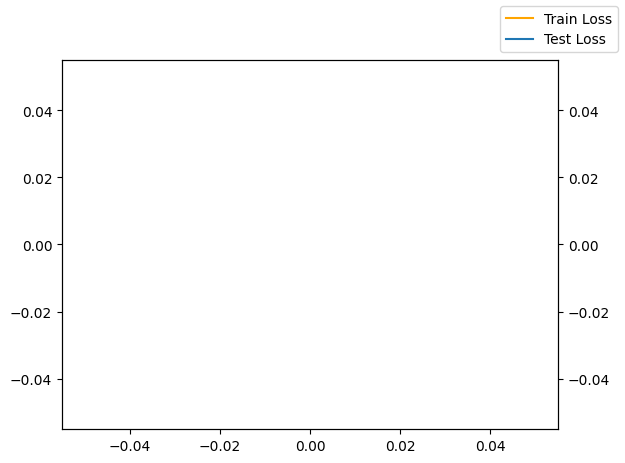

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(train_loss[20:], label = "Train Loss", color = "orange")
ax2.plot(test_loss[20:], label = "Test Loss")
fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")
plt.show()

              precision    recall  f1-score   support

           0       0.62      0.63      0.62       865
           1       0.71      0.70      0.71      1135

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000

              precision    recall  f1-score   support

           0       0.60      0.66      0.63       865
           1       0.72      0.66      0.69      1135

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.67      0.66      0.66      2000

              precision    recall  f1-score   support

           0       0.58      0.70      0.63       865
           1       0.73      0.61      0.67      1135

    accuracy                           0.65      2000
   macro avg       0.65      0.66      0.65      2000
weighted avg       0.66      0.65      0.65      2000

              preci

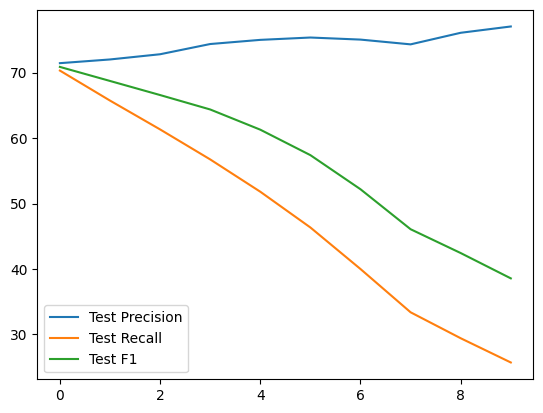

In [ ]:
prs = []
rec = []
f1 = []
loss = []

for i in np.arange(3, 4, 0.1):
    l, p, r, f, _, _, _ = sm_net.evaluate(i)
    prs.append(p)
    rec.append(r)
    f1.append(f)
    loss.append(l)

plt.plot(prs, label = "Test Precision")
plt.plot(rec, label = "Test Recall")
plt.plot(f1, label = "Test F1")

plt.legend()
plt.show()

# **(Video + Audio)**

In [ ]:
class SiameseNet6(nn.Module):
    def __init__(self, device = device, channel = 84):
        super(SiameseNet6, self).__init__()
        self.encoder_user = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.user_embedding_size, 1024)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1024, channel)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_item = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.item_embedding_size, 256)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(256, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_video = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.video_embedding_size, 1600)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1600, 300)),
            ('relu2', nn.LeakyReLU()),
#             ('linr3', nn.Linear(1000, 500)),
#             ('relu3', nn.LeakyReLU()),
# #             ('norm2', nn.BatchNorm1d(500)),
#             ('linr4', nn.Linear(500, 300)),
#             ('relu4', nn.LeakyReLU()),
        ]))

        self.encoder_audio = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.audio_embedding_size, 600)),
            ('relu1', nn.LeakyReLU()),
            ('linr4', nn.Linear(600, 300)),
            ('relu4', nn.LeakyReLU()),
        ]))

        #self.encoder_text = nn.Sequential(OrderedDict([
        #    ('linr1', nn.Linear(train_dataset.text_embedding_size, 256)),
        #    ('relu1', nn.LeakyReLU()),
        #    ('linr2', nn.Linear(256, 300)),
        #    ('relu2', nn.LeakyReLU()),
        #]))

        #self.encoder_meta = nn.Sequential(OrderedDict([
        #    ('linr1', nn.Linear(train_dataset.meta_embedding_size, 1600)),
        #    ('relu1', nn.LeakyReLU()),
#             ('norm1', nn.BatchNorm1d(1600)),
        #    ('linr2', nn.Linear(1600, 300)),
        #    ('relu2', nn.LeakyReLU()),
#             ('linr3', nn.Linear(1000, 500)),
#             ('relu3', nn.LeakyReLU()),
#             ('linr4', nn.Linear(500, 300)),
#             ('relu4', nn.LeakyReLU()),
        #]))

        self.fusion = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, 1, (20, 20), stride=(2, 2))),
            ('relu1', nn.LeakyReLU()),
            ('conv2', nn.Conv2d(1, 1, (5, 50), stride=(1, 1))),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.siamese = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(channel, 200)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(200, 256)),
            ('relu2', nn.LeakyReLU()),
            ('linr3', nn.Linear(256, 100)),
            ('relu3', nn.LeakyReLU()),
        ]))

        self.ffn = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(300, 164)),
            ('actv1', nn.ReLU()),
            ('linr2', nn.Linear(164, 1)),
#             ('actv2', nn.ReLU()),
#             ('linr3', nn.Linear(50, 1)),
        ]))

        self.device = device
        self.encoder_user.apply(self.init_weights)
        self.encoder_item.apply(self.init_weights)
        self.encoder_video.apply(self.init_weights)
        self.encoder_audio.apply(self.init_weights)
        #self.encoder_text.apply(self.init_weights)
        #self.encoder_meta.apply(self.init_weights)
        self.siamese.apply(self.init_weights)
        self.ffn.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

    def exp(self, q, k, v):
        z = torch.bmm(q, k.permute(0, 2, 1))
        z = F.normalize(z, p = 10, dim = 1)
        z = torch.softmax(z, 1)
        z = torch.bmm(z, v)
        return(z)

    def forward(self, x1, x2):
        # Modality-encoders
        outu = self.encoder_user(x1)
        outr = self.encoder_item(x2[3])
        outv = torch.split(self.encoder_video(x2[0]), [100, 100, 100], 1)
        outa = torch.split(self.encoder_audio(x2[1]), [100, 100, 100], 1)
        #outt = torch.split(self.encoder_text(x2[2]), 100, 1)
        #outm = torch.split(self.encoder_meta(x2[4]), [100, 100, 100], 1)

        # Attention
        #q_t = outt[0].unsqueeze(1).repeat(1, ROW, 1)
        #k_t = outt[1].unsqueeze(1).repeat(1, ROW, 1)
        #v_t = outt[2].unsqueeze(1).repeat(1, ROW, 1)

        q_a = outa[0].unsqueeze(1).repeat(1, ROW, 1)
        k_a = outa[1].unsqueeze(1).repeat(1, ROW, 1)
        v_a = outa[2].unsqueeze(1).repeat(1, ROW, 1)

        q_v = outv[0].unsqueeze(1).repeat(1, ROW, 1)
        k_v = outv[1].unsqueeze(1).repeat(1, ROW, 1)
        v_v = outv[2].unsqueeze(1).repeat(1, ROW, 1)

        #q_m = outm[0].unsqueeze(1).repeat(1, ROW, 1)
        #k_m = outm[1].unsqueeze(1).repeat(1, ROW, 1)
        #v_m = outm[2].unsqueeze(1).repeat(1, ROW, 1)

        # Self-Attention
        #st = self.exp(q_t, k_t, v_t)
        #sm = self.exp(q_m, k_m, v_m)
        sa = self.exp(q_a, k_a, v_a)
        sv = self.exp(q_v, k_v, v_v)

        # Inter-Modal Attention
        ita = self.exp(q_a, k_v, v_a)
        imv = self.exp(q_v, k_a, v_v)
        #itm = self.exp(q_m, k_t, v_m)

        # Forward
        ma = torch.mean(torch.stack([sa, ita]), 0)
        mv = torch.mean(torch.stack([sv, imv]), 0)
        sda = ita
        se = torch.mul(ma, mv)
        outi = torch.cat((sda, se), axis = 2)#.reshape(-1, ROW * 1200)
        outi = self.fusion(outi.unsqueeze(1))
        out1 = self.siamese(outu)
        out2 = self.siamese(outi.reshape(BATCH, -1))
        diff = torch.cat((out1, out2, outv[2]), axis=1)
        out = self.ffn(diff)
        return(out, out1, out2)

    def fit(self, trainloader = trainloader,
            testloader = testloader, epochs = 1):
        self.criterion_rate = weighted_mse_loss
        self.criterion_embd = nn.CosineEmbeddingLoss()
        self.optimizer = optim.Adam(self.parameters(), lr = 1e-4)

        train_loss = []
        train_f1 = []
        test_loss = []
        test_f1 = []
        for epoch in range(epochs):
            running_loss = 0.0
            running_loss_1 = 0.0

            for i, data in tqdm(enumerate(trainloader)):
                self.train()
                x1, x2, y = data
                y_flt = y.type(torch.FloatTensor).to(device)
                y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
                self.optimizer.zero_grad()
                reg, outu, outi = self.forward(x1, x2)
                loss_1, loss_ = self.criterion_rate(reg.squeeze(), y_flt)
                loss_2 = self.criterion_embd(outu, outi, y_lng * 2 - 1)
                loss = loss_1 + loss_2
                loss.backward()
                self.optimizer.step()

                running_loss_1 += torch.sqrt(loss_)
                running_loss += loss
            vl, vp, vr, vf, tp, tr, tf = self.evaluate()
            print('Epoch-%d: Loss = %.3f\nTrain RMSE = %.3f||Train Precision = %.3f||Train Recall = %.3f\nTest RMSE = %.3f || Test Precision = %.3f|| Test Recall = %.3f'%
                  (epoch + 1, running_loss / i, running_loss_1 / i,
                   tp, tr, vl, vp, vr))
            train_loss.append((running_loss_1 / i).cpu().detach().numpy())
            test_loss.append(vl.cpu().detach().numpy())
            train_f1.append(tf)
            test_f1.append(vf)
        return(train_loss, test_loss, train_f1, test_f1)

    def evaluate(self, k = 3.5):
        self.eval()
        with torch.no_grad():
            valdata = next(iter(testloader))
            x1, x2, y = valdata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            vl = torch.sqrt(self.criterion_rate(otpt[0].squeeze(), y_flt)[1])
            vp = precision_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            vr = recall_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            vf = f1_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            print(classification_report(y_lng.cpu(), pred.cpu(),
                    target_names = ["0", "1"], zero_division = 0))

            traindata = next(iter(trainloader))
            x1, x2, y = traindata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            tp = precision_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            tr = recall_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            tf = f1_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
        return(vl, vp*100, vr*100, vf*100, tp*100, tr*100, tf*100)

In [ ]:
sm_net = SiameseNet5()
sm_net.to(device)

SiameseNet5(
  (encoder_user): Sequential(
    (linr1): Linear(in_features=1220, out_features=1024, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1024, out_features=84, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_item): Sequential(
    (linr1): Linear(in_features=943, out_features=256, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=256, out_features=300, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_video): Sequential(
    (linr1): Linear(in_features=1024, out_features=1600, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1600, out_features=300, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_text): Sequential(
    (linr1): Linear(in_features=384, out_features=256, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=256, out_features=300, bias=True)
    (relu2): 

In [ ]:
train_loss, test_loss, train_f1, test_f1 = sm_net.fit()

40it [03:06,  4.66s/it]


              precision    recall  f1-score   support

           0       0.43      0.99      0.60       865
           1       0.42      0.00      0.01      1135

    accuracy                           0.43      2000
   macro avg       0.42      0.50      0.31      2000
weighted avg       0.42      0.43      0.27      2000

Epoch-1: Loss = 7.363
Train RMSE = 1.932||Train Precision = 66.667||Train Recall = 0.553
Test RMSE = 1.560 || Test Precision = 41.667|| Test Recall = 0.441


40it [03:04,  4.60s/it]


              precision    recall  f1-score   support

           0       0.43      0.95      0.59       865
           1       0.35      0.02      0.04      1135

    accuracy                           0.42      2000
   macro avg       0.39      0.49      0.31      2000
weighted avg       0.38      0.42      0.27      2000

Epoch-2: Loss = 4.053
Train RMSE = 1.301||Train Precision = 60.526||Train Recall = 2.100
Test RMSE = 1.399 || Test Precision = 35.000|| Test Recall = 1.850


40it [03:04,  4.62s/it]


              precision    recall  f1-score   support

           0       0.43      0.96      0.59       865
           1       0.36      0.02      0.04      1135

    accuracy                           0.42      2000
   macro avg       0.39      0.49      0.31      2000
weighted avg       0.39      0.42      0.28      2000

Epoch-3: Loss = 3.895
Train RMSE = 1.262||Train Precision = 67.500||Train Recall = 2.495
Test RMSE = 1.380 || Test Precision = 36.207|| Test Recall = 1.850


40it [03:05,  4.64s/it]


              precision    recall  f1-score   support

           0       0.43      0.98      0.60       865
           1       0.45      0.01      0.03      1135

    accuracy                           0.43      2000
   macro avg       0.44      0.50      0.31      2000
weighted avg       0.44      0.43      0.27      2000

Epoch-4: Loss = 3.728
Train RMSE = 1.227||Train Precision = 76.271||Train Recall = 4.194
Test RMSE = 1.377 || Test Precision = 44.737|| Test Recall = 1.498


40it [03:05,  4.65s/it]


              precision    recall  f1-score   support

           0       0.44      0.95      0.60       865
           1       0.65      0.07      0.13      1135

    accuracy                           0.45      2000
   macro avg       0.55      0.51      0.37      2000
weighted avg       0.56      0.45      0.33      2000

Epoch-5: Loss = 3.542
Train RMSE = 1.196||Train Precision = 74.854||Train Recall = 11.951
Test RMSE = 1.360 || Test Precision = 65.354|| Test Recall = 7.313


40it [03:05,  4.63s/it]


              precision    recall  f1-score   support

           0       0.46      0.83      0.59       865
           1       0.67      0.26      0.37      1135

    accuracy                           0.51      2000
   macro avg       0.56      0.54      0.48      2000
weighted avg       0.58      0.51      0.47      2000

Epoch-6: Loss = 3.369
Train RMSE = 1.170||Train Precision = 76.798||Train Recall = 30.906
Test RMSE = 1.293 || Test Precision = 66.591|| Test Recall = 25.815


40it [03:04,  4.61s/it]


              precision    recall  f1-score   support

           0       0.47      0.81      0.59       865
           1       0.67      0.29      0.41      1135

    accuracy                           0.52      2000
   macro avg       0.57      0.55      0.50      2000
weighted avg       0.58      0.52      0.49      2000

Epoch-7: Loss = 3.236
Train RMSE = 1.150||Train Precision = 74.692||Train Recall = 38.254
Test RMSE = 1.284 || Test Precision = 67.002|| Test Recall = 29.339


40it [03:04,  4.61s/it]


              precision    recall  f1-score   support

           0       0.48      0.77      0.59       865
           1       0.67      0.37      0.48      1135

    accuracy                           0.54      2000
   macro avg       0.58      0.57      0.53      2000
weighted avg       0.59      0.54      0.53      2000

Epoch-8: Loss = 3.149
Train RMSE = 1.137||Train Precision = 74.722||Train Recall = 48.208
Test RMSE = 1.252 || Test Precision = 67.363|| Test Recall = 36.916


40it [03:06,  4.66s/it]


              precision    recall  f1-score   support

           0       0.47      0.85      0.61       865
           1       0.71      0.28      0.40      1135

    accuracy                           0.53      2000
   macro avg       0.59      0.56      0.50      2000
weighted avg       0.61      0.53      0.49      2000

Epoch-9: Loss = 3.074
Train RMSE = 1.125||Train Precision = 78.216||Train Recall = 34.875
Test RMSE = 1.287 || Test Precision = 70.575|| Test Recall = 28.106


23it [01:46,  4.62s/it]

<ipython-input-88-abf663b56279>:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")


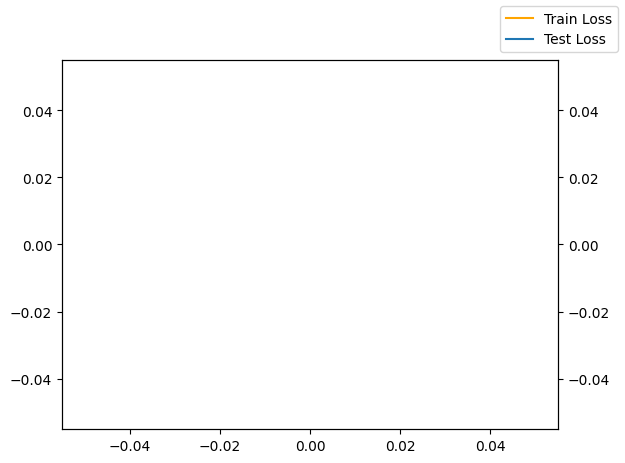

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(train_loss[20:], label = "Train Loss", color = "orange")
ax2.plot(test_loss[20:], label = "Test Loss")
fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")
plt.show()

              precision    recall  f1-score   support

           0       0.64      0.55      0.59       865
           1       0.69      0.76      0.73      1135

    accuracy                           0.67      2000
   macro avg       0.67      0.66      0.66      2000
weighted avg       0.67      0.67      0.67      2000

              precision    recall  f1-score   support

           0       0.62      0.61      0.62       865
           1       0.71      0.72      0.71      1135

    accuracy                           0.67      2000
   macro avg       0.67      0.66      0.67      2000
weighted avg       0.67      0.67      0.67      2000

              precision    recall  f1-score   support

           0       0.60      0.65      0.62       865
           1       0.71      0.67      0.69      1135

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.66      0.66      0.66      2000

              preci

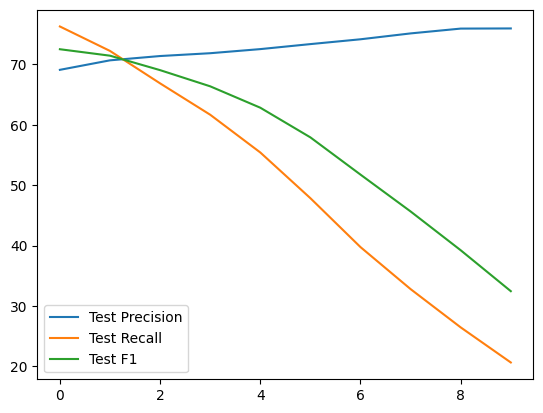

In [ ]:
prs = []
rec = []
f1 = []
loss = []

for i in np.arange(3, 4, 0.1):
    l, p, r, f, _, _, _ = sm_net.evaluate(i)
    prs.append(p)
    rec.append(r)
    f1.append(f)
    loss.append(l)

plt.plot(prs, label = "Test Precision")
plt.plot(rec, label = "Test Recall")
plt.plot(f1, label = "Test F1")

plt.legend()
plt.show()

# **(Meta + Audio + Video)**

In [ ]:
class SiameseNet6(nn.Module):
    def __init__(self, device = device, channel = 84):
        super(SiameseNet6, self).__init__()
        self.encoder_user = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.user_embedding_size, 1024)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1024, channel)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_item = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.item_embedding_size, 256)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(256, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_video = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.video_embedding_size, 1600)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1600, 300)),
            ('relu2', nn.LeakyReLU()),
#             ('linr3', nn.Linear(1000, 500)),
#             ('relu3', nn.LeakyReLU()),
# #             ('norm2', nn.BatchNorm1d(500)),
#             ('linr4', nn.Linear(500, 300)),
#             ('relu4', nn.LeakyReLU()),
        ]))

        self.encoder_audio = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.audio_embedding_size, 600)),
            ('relu1', nn.LeakyReLU()),
            ('linr4', nn.Linear(600, 300)),
            ('relu4', nn.LeakyReLU()),
        ]))

        #self.encoder_text = nn.Sequential(OrderedDict([
        #    ('linr1', nn.Linear(train_dataset.text_embedding_size, 256)),
        #    ('relu1', nn.LeakyReLU()),
        #    ('linr2', nn.Linear(256, 300)),
        #    ('relu2', nn.LeakyReLU()),
        #]))

        self.encoder_meta = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.meta_embedding_size, 1600)),
            ('relu1', nn.LeakyReLU()),
#             ('norm1', nn.BatchNorm1d(1600)),
            ('linr2', nn.Linear(1600, 300)),
            ('relu2', nn.LeakyReLU()),
#             ('linr3', nn.Linear(1000, 500)),
#             ('relu3', nn.LeakyReLU()),
#             ('linr4', nn.Linear(500, 300)),
#             ('relu4', nn.LeakyReLU()),
        ]))

        self.fusion = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, 1, (20, 20), stride=(2, 2))),
            ('relu1', nn.LeakyReLU()),
            ('conv2', nn.Conv2d(1, 1, (5, 50), stride=(1, 1))),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.siamese = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(channel, 200)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(200, 256)),
            ('relu2', nn.LeakyReLU()),
            ('linr3', nn.Linear(256, 100)),
            ('relu3', nn.LeakyReLU()),
        ]))

        self.ffn = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(300, 164)),
            ('actv1', nn.ReLU()),
            ('linr2', nn.Linear(164, 1)),
#             ('actv2', nn.ReLU()),
#             ('linr3', nn.Linear(50, 1)),
        ]))

        self.device = device
        self.encoder_user.apply(self.init_weights)
        self.encoder_item.apply(self.init_weights)
        self.encoder_video.apply(self.init_weights)
        self.encoder_audio.apply(self.init_weights)
        #self.encoder_text.apply(self.init_weights)
        self.encoder_meta.apply(self.init_weights)
        self.siamese.apply(self.init_weights)
        self.ffn.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

    def exp(self, q, k, v):
        z = torch.bmm(q, k.permute(0, 2, 1))
        z = F.normalize(z, p = 10, dim = 1)
        z = torch.softmax(z, 1)
        z = torch.bmm(z, v)
        return(z)

    def forward(self, x1, x2):
        # Modality-encoders
        outu = self.encoder_user(x1)
        outr = self.encoder_item(x2[3])
        outv = torch.split(self.encoder_video(x2[0]), [100, 100, 100], 1)
        outa = torch.split(self.encoder_audio(x2[1]), [100, 100, 100], 1)
       # outt = torch.split(self.encoder_text(x2[2]), 100, 1)
        outm = torch.split(self.encoder_meta(x2[4]), [100, 100, 100], 1)

        # Attention
        #q_t = outt[0].unsqueeze(1).repeat(1, ROW, 1)
        #k_t = outt[1].unsqueeze(1).repeat(1, ROW, 1)
        #v_t = outt[2].unsqueeze(1).repeat(1, ROW, 1)

        q_a = outa[0].unsqueeze(1).repeat(1, ROW, 1)
        k_a = outa[1].unsqueeze(1).repeat(1, ROW, 1)
        v_a = outa[2].unsqueeze(1).repeat(1, ROW, 1)

        q_v = outv[0].unsqueeze(1).repeat(1, ROW, 1)
        k_v = outv[1].unsqueeze(1).repeat(1, ROW, 1)
        v_v = outv[2].unsqueeze(1).repeat(1, ROW, 1)

        q_m = outm[0].unsqueeze(1).repeat(1, ROW, 1)
        k_m = outm[1].unsqueeze(1).repeat(1, ROW, 1)
        v_m = outm[2].unsqueeze(1).repeat(1, ROW, 1)

        # Self-Attention
        #st = self.exp(q_t, k_t, v_t)
        sm = self.exp(q_m, k_m, v_m)
        sa = self.exp(q_a, k_a, v_a)
        sv = self.exp(q_v, k_v, v_v)

        # Inter-Modal Attention
        ita = self.exp(q_a, k_m, v_a)
        imv = self.exp(q_v, k_a, v_v)
        itm = self.exp(q_m, k_v, v_m)

        # Forward
        ma = torch.mean(torch.stack([sa, ita]), 0)
        mv = torch.mean(torch.stack([sv, imv]), 0)
        sda = itm
        se = torch.mul(ma, mv)
        outi = torch.cat((sda, se), axis = 2)#.reshape(-1, ROW * 1200)
        outi = self.fusion(outi.unsqueeze(1))
        out1 = self.siamese(outu)
        out2 = self.siamese(outi.reshape(BATCH, -1))
        diff = torch.cat((out1, out2, outm[2]), axis=1)
        out = self.ffn(diff)
        return(out, out1, out2)

    def fit(self, trainloader = trainloader,
            testloader = testloader, epochs = 20):
        self.criterion_rate = weighted_mse_loss
        self.criterion_embd = nn.CosineEmbeddingLoss()
        self.optimizer = optim.Adam(self.parameters(), lr = 1e-4)

        train_loss = []
        train_f1 = []
        test_loss = []
        test_f1 = []
        for epoch in range(epochs):
            running_loss = 0.0
            running_loss_1 = 0.0

            for i, data in tqdm(enumerate(trainloader)):
                self.train()
                x1, x2, y = data
                y_flt = y.type(torch.FloatTensor).to(device)
                y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
                self.optimizer.zero_grad()
                reg, outu, outi = self.forward(x1, x2)
                loss_1, loss_ = self.criterion_rate(reg.squeeze(), y_flt)
                loss_2 = self.criterion_embd(outu, outi, y_lng * 2 - 1)
                loss = loss_1 + loss_2
                loss.backward()
                self.optimizer.step()

                running_loss_1 += torch.sqrt(loss_)
                running_loss += loss
            vl, vp, vr, vf, tp, tr, tf = self.evaluate()
            print('Epoch-%d: Loss = %.3f\nTrain RMSE = %.3f||Train Precision = %.3f||Train Recall = %.3f\nTest RMSE = %.3f || Test Precision = %.3f|| Test Recall = %.3f'%
                  (epoch + 1, running_loss / i, running_loss_1 / i,
                   tp, tr, vl, vp, vr))
            train_loss.append((running_loss_1 / i).cpu().detach().numpy())
            test_loss.append(vl.cpu().detach().numpy())
            train_f1.append(tf)
            test_f1.append(vf)
        return(train_loss, test_loss, train_f1, test_f1)

    def evaluate(self, k = 3.5):
        self.eval()
        with torch.no_grad():
            valdata = next(iter(testloader))
            x1, x2, y = valdata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            vl = torch.sqrt(self.criterion_rate(otpt[0].squeeze(), y_flt)[1])
            vp = precision_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            vr = recall_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            vf = f1_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            print(classification_report(y_lng.cpu(), pred.cpu(),
                    target_names = ["0", "1"], zero_division = 0))

            traindata = next(iter(trainloader))
            x1, x2, y = traindata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            tp = precision_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            tr = recall_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            tf = f1_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
        return(vl, vp*100, vr*100, vf*100, tp*100, tr*100, tf*100)

In [ ]:
sm_net = SiameseNet6()
sm_net.to(device)

SiameseNet6(
  (encoder_user): Sequential(
    (linr1): Linear(in_features=1220, out_features=1024, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1024, out_features=84, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_item): Sequential(
    (linr1): Linear(in_features=943, out_features=256, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=256, out_features=300, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_video): Sequential(
    (linr1): Linear(in_features=1024, out_features=1600, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1600, out_features=300, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_audio): Sequential(
    (linr1): Linear(in_features=1024, out_features=600, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr4): Linear(in_features=600, out_features=300, bias=True)
    (relu4)

In [ ]:
train_loss, test_loss, train_f1, test_f1 = sm_net.fit()

40it [00:32,  1.24it/s]


              precision    recall  f1-score   support

           0       0.43      0.98      0.60       865
           1       0.54      0.02      0.04      1135

    accuracy                           0.43      2000
   macro avg       0.49      0.50      0.32      2000
weighted avg       0.49      0.43      0.28      2000

Epoch-1: Loss = 7.268
Train RMSE = 1.936||Train Precision = 56.250||Train Recall = 0.797
Test RMSE = 1.571 || Test Precision = 53.846|| Test Recall = 1.850


40it [00:32,  1.23it/s]


              precision    recall  f1-score   support

           0       0.44      0.90      0.59       865
           1       0.64      0.13      0.22      1135

    accuracy                           0.47      2000
   macro avg       0.54      0.52      0.41      2000
weighted avg       0.55      0.47      0.38      2000

Epoch-2: Loss = 4.093
Train RMSE = 1.336||Train Precision = 79.018||Train Recall = 15.608
Test RMSE = 1.382 || Test Precision = 64.069|| Test Recall = 13.040


40it [00:32,  1.22it/s]


              precision    recall  f1-score   support

           0       0.46      0.89      0.61       865
           1       0.72      0.21      0.32      1135

    accuracy                           0.50      2000
   macro avg       0.59      0.55      0.46      2000
weighted avg       0.61      0.50      0.45      2000

Epoch-3: Loss = 3.701
Train RMSE = 1.251||Train Precision = 75.241||Train Recall = 20.912
Test RMSE = 1.331 || Test Precision = 71.779|| Test Recall = 20.617


40it [00:31,  1.25it/s]


              precision    recall  f1-score   support

           0       0.47      0.80      0.59       865
           1       0.67      0.32      0.43      1135

    accuracy                           0.52      2000
   macro avg       0.57      0.56      0.51      2000
weighted avg       0.58      0.52      0.50      2000

Epoch-4: Loss = 3.386
Train RMSE = 1.196||Train Precision = 73.577||Train Recall = 33.674
Test RMSE = 1.281 || Test Precision = 66.978|| Test Recall = 31.630


40it [00:33,  1.21it/s]


              precision    recall  f1-score   support

           0       0.48      0.79      0.59       865
           1       0.68      0.35      0.46      1135

    accuracy                           0.54      2000
   macro avg       0.58      0.57      0.53      2000
weighted avg       0.59      0.54      0.52      2000

Epoch-5: Loss = 3.112
Train RMSE = 1.145||Train Precision = 79.626||Train Recall = 38.378
Test RMSE = 1.273 || Test Precision = 68.048|| Test Recall = 34.714


40it [00:32,  1.23it/s]


              precision    recall  f1-score   support

           0       0.51      0.70      0.59       865
           1       0.68      0.50      0.57      1135

    accuracy                           0.58      2000
   macro avg       0.60      0.60      0.58      2000
weighted avg       0.61      0.58      0.58      2000

Epoch-6: Loss = 2.907
Train RMSE = 1.109||Train Precision = 74.969||Train Recall = 55.302
Test RMSE = 1.235 || Test Precision = 68.325|| Test Recall = 49.604


40it [00:32,  1.22it/s]


              precision    recall  f1-score   support

           0       0.51      0.75      0.61       865
           1       0.70      0.46      0.55      1135

    accuracy                           0.58      2000
   macro avg       0.61      0.60      0.58      2000
weighted avg       0.62      0.58      0.58      2000

Epoch-7: Loss = 2.754
Train RMSE = 1.083||Train Precision = 75.758||Train Recall = 50.598
Test RMSE = 1.241 || Test Precision = 70.230|| Test Recall = 45.727


40it [00:33,  1.21it/s]


              precision    recall  f1-score   support

           0       0.51      0.77      0.61       865
           1       0.72      0.43      0.54      1135

    accuracy                           0.58      2000
   macro avg       0.61      0.60      0.58      2000
weighted avg       0.63      0.58      0.57      2000

Epoch-8: Loss = 2.651
Train RMSE = 1.066||Train Precision = 75.617||Train Recall = 49.244
Test RMSE = 1.246 || Test Precision = 71.512|| Test Recall = 43.348


40it [00:33,  1.18it/s]


              precision    recall  f1-score   support

           0       0.52      0.72      0.60       865
           1       0.70      0.48      0.57      1135

    accuracy                           0.59      2000
   macro avg       0.61      0.60      0.59      2000
weighted avg       0.62      0.59      0.58      2000

Epoch-9: Loss = 2.591
Train RMSE = 1.057||Train Precision = 77.403||Train Recall = 55.258
Test RMSE = 1.234 || Test Precision = 69.670|| Test Recall = 48.370


40it [00:34,  1.17it/s]


              precision    recall  f1-score   support

           0       0.52      0.74      0.61       865
           1       0.71      0.48      0.57      1135

    accuracy                           0.59      2000
   macro avg       0.62      0.61      0.59      2000
weighted avg       0.63      0.59      0.59      2000

Epoch-10: Loss = 2.560
Train RMSE = 1.054||Train Precision = 76.667||Train Recall = 52.801
Test RMSE = 1.221 || Test Precision = 70.980|| Test Recall = 47.841


40it [00:35,  1.13it/s]


              precision    recall  f1-score   support

           0       0.53      0.72      0.61       865
           1       0.70      0.51      0.59      1135

    accuracy                           0.60      2000
   macro avg       0.62      0.61      0.60      2000
weighted avg       0.63      0.60      0.60      2000

Epoch-11: Loss = 2.546
Train RMSE = 1.055||Train Precision = 75.386||Train Recall = 58.922
Test RMSE = 1.214 || Test Precision = 70.402|| Test Recall = 50.925


40it [00:35,  1.14it/s]


              precision    recall  f1-score   support

           0       0.52      0.74      0.61       865
           1       0.71      0.47      0.56      1135

    accuracy                           0.59      2000
   macro avg       0.61      0.61      0.59      2000
weighted avg       0.62      0.59      0.58      2000

Epoch-12: Loss = 2.522
Train RMSE = 1.049||Train Precision = 80.129||Train Recall = 55.200
Test RMSE = 1.228 || Test Precision = 70.596|| Test Recall = 46.960


40it [00:35,  1.13it/s]


              precision    recall  f1-score   support

           0       0.51      0.73      0.60       865
           1       0.69      0.46      0.55      1135

    accuracy                           0.58      2000
   macro avg       0.60      0.60      0.58      2000
weighted avg       0.61      0.58      0.57      2000

Epoch-13: Loss = 2.510
Train RMSE = 1.047||Train Precision = 79.708||Train Recall = 53.757
Test RMSE = 1.233 || Test Precision = 69.292|| Test Recall = 45.727


40it [00:34,  1.16it/s]


              precision    recall  f1-score   support

           0       0.52      0.72      0.60       865
           1       0.70      0.50      0.58      1135

    accuracy                           0.59      2000
   macro avg       0.61      0.61      0.59      2000
weighted avg       0.62      0.59      0.59      2000

Epoch-14: Loss = 2.508
Train RMSE = 1.048||Train Precision = 76.590||Train Recall = 54.381
Test RMSE = 1.230 || Test Precision = 69.678|| Test Recall = 49.604


40it [00:34,  1.15it/s]


              precision    recall  f1-score   support

           0       0.54      0.65      0.59       865
           1       0.68      0.58      0.63      1135

    accuracy                           0.61      2000
   macro avg       0.61      0.61      0.61      2000
weighted avg       0.62      0.61      0.61      2000

Epoch-15: Loss = 2.509
Train RMSE = 1.050||Train Precision = 74.317||Train Recall = 60.932
Test RMSE = 1.220 || Test Precision = 68.154|| Test Recall = 57.885


40it [00:33,  1.18it/s]


              precision    recall  f1-score   support

           0       0.51      0.74      0.61       865
           1       0.70      0.47      0.56      1135

    accuracy                           0.59      2000
   macro avg       0.61      0.60      0.58      2000
weighted avg       0.62      0.59      0.58      2000

Epoch-16: Loss = 2.497
Train RMSE = 1.048||Train Precision = 78.784||Train Recall = 56.077
Test RMSE = 1.231 || Test Precision = 70.292|| Test Recall = 46.696


40it [00:34,  1.16it/s]


              precision    recall  f1-score   support

           0       0.51      0.74      0.60       865
           1       0.70      0.46      0.56      1135

    accuracy                           0.58      2000
   macro avg       0.61      0.60      0.58      2000
weighted avg       0.62      0.58      0.58      2000

Epoch-17: Loss = 2.485
Train RMSE = 1.044||Train Precision = 77.389||Train Recall = 51.570
Test RMSE = 1.239 || Test Precision = 69.960|| Test Recall = 46.167


40it [00:34,  1.17it/s]


              precision    recall  f1-score   support

           0       0.51      0.74      0.61       865
           1       0.70      0.46      0.56      1135

    accuracy                           0.58      2000
   macro avg       0.61      0.60      0.58      2000
weighted avg       0.62      0.58      0.58      2000

Epoch-18: Loss = 2.479
Train RMSE = 1.043||Train Precision = 76.616||Train Recall = 51.007
Test RMSE = 1.235 || Test Precision = 70.161|| Test Recall = 45.991


40it [00:34,  1.17it/s]


              precision    recall  f1-score   support

           0       0.52      0.70      0.60       865
           1       0.69      0.51      0.58      1135

    accuracy                           0.59      2000
   macro avg       0.60      0.60      0.59      2000
weighted avg       0.62      0.59      0.59      2000

Epoch-19: Loss = 2.490
Train RMSE = 1.047||Train Precision = 79.064||Train Recall = 57.321
Test RMSE = 1.232 || Test Precision = 68.982|| Test Recall = 50.749


40it [00:35,  1.14it/s]


              precision    recall  f1-score   support

           0       0.55      0.68      0.61       865
           1       0.70      0.57      0.63      1135

    accuracy                           0.62      2000
   macro avg       0.62      0.63      0.62      2000
weighted avg       0.63      0.62      0.62      2000

Epoch-20: Loss = 2.471
Train RMSE = 1.044||Train Precision = 73.864||Train Recall = 59.853
Test RMSE = 1.211 || Test Precision = 70.153|| Test Recall = 56.740


In [ ]:
sm_net.evaluate(k=3.5)

              precision    recall  f1-score   support

           0       0.55      0.68      0.61       865
           1       0.70      0.57      0.63      1135

    accuracy                           0.62      2000
   macro avg       0.62      0.63      0.62      2000
weighted avg       0.63      0.62      0.62      2000



(tensor(1.2111, device='cuda:0'),
 70.1525054466231,
 56.74008810572687,
 62.73745737944472,
 74.05281285878301,
 60.280373831775705,
 66.46058732612056)

<ipython-input-34-abf663b56279>:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")


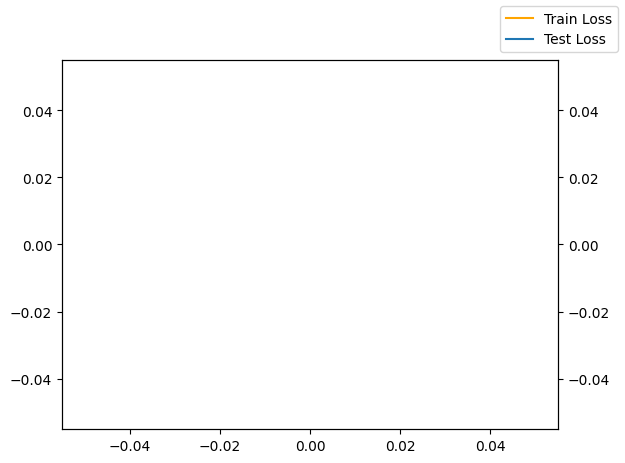

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(train_loss[20:], label = "Train Loss", color = "orange")
ax2.plot(test_loss[20:], label = "Test Loss")
fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")
plt.show()

              precision    recall  f1-score   support

           0       0.65      0.41      0.50       865
           1       0.65      0.83      0.73      1135

    accuracy                           0.65      2000
   macro avg       0.65      0.62      0.61      2000
weighted avg       0.65      0.65      0.63      2000

              precision    recall  f1-score   support

           0       0.62      0.47      0.53       865
           1       0.66      0.79      0.72      1135

    accuracy                           0.65      2000
   macro avg       0.64      0.63      0.63      2000
weighted avg       0.64      0.65      0.64      2000

              precision    recall  f1-score   support

           0       0.60      0.52      0.56       865
           1       0.67      0.74      0.70      1135

    accuracy                           0.65      2000
   macro avg       0.64      0.63      0.63      2000
weighted avg       0.64      0.65      0.64      2000

              preci

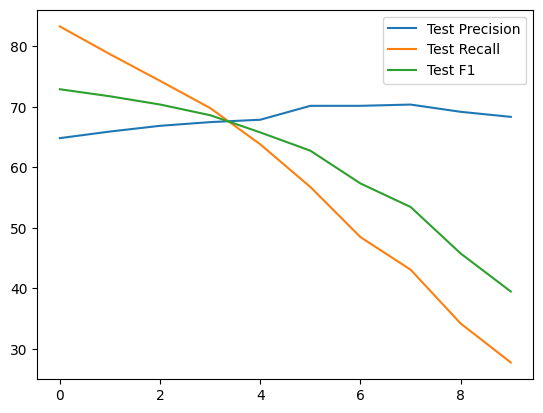

In [ ]:
prs = []
rec = []
f1 = []
loss = []

for i in np.arange(3, 4, 0.1):
    l, p, r, f, _, _, _ = sm_net.evaluate(i)
    prs.append(p)
    rec.append(r)
    f1.append(f)
    loss.append(l)

plt.plot(prs, label = "Test Precision")
plt.plot(rec, label = "Test Recall")
plt.plot(f1, label = "Test F1")

plt.legend()
plt.show()

# **(Meta + Text + Audio)**

In [ ]:
class SiameseNet7(nn.Module):
    def __init__(self, device = device, channel = 84):
        super(SiameseNet7, self).__init__()
        self.encoder_user = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.user_embedding_size, 1024)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1024, channel)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_item = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.item_embedding_size, 256)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(256, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))

        #self.encoder_video = nn.Sequential(OrderedDict([
        #    ('linr1', nn.Linear(train_dataset.video_embedding_size, 1600)),
        #    ('relu1', nn.LeakyReLU()),
        #    ('linr2', nn.Linear(1600, 300)),
        #    ('relu2', nn.LeakyReLU()),
#             ('linr3', nn.Linear(1000, 500)),
#             ('relu3', nn.LeakyReLU()),
# #             ('norm2', nn.BatchNorm1d(500)),
#             ('linr4', nn.Linear(500, 300)),
#             ('relu4', nn.LeakyReLU()),
        #]))

        self.encoder_audio = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.audio_embedding_size, 600)),
            ('relu1', nn.LeakyReLU()),
            ('linr4', nn.Linear(600, 300)),
            ('relu4', nn.LeakyReLU()),
        ]))

        self.encoder_text = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.text_embedding_size, 256)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(256, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_meta = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.meta_embedding_size, 1600)),
            ('relu1', nn.LeakyReLU()),
#             ('norm1', nn.BatchNorm1d(1600)),
            ('linr2', nn.Linear(1600, 300)),
            ('relu2', nn.LeakyReLU()),
#             ('linr3', nn.Linear(1000, 500)),
#             ('relu3', nn.LeakyReLU()),
#             ('linr4', nn.Linear(500, 300)),
#             ('relu4', nn.LeakyReLU()),
        ]))

        self.fusion = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, 1, (20, 20), stride=(2, 2))),
            ('relu1', nn.LeakyReLU()),
            ('conv2', nn.Conv2d(1, 1, (5, 50), stride=(1, 1))),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.siamese = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(channel, 200)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(200, 256)),
            ('relu2', nn.LeakyReLU()),
            ('linr3', nn.Linear(256, 100)),
            ('relu3', nn.LeakyReLU()),
        ]))

        self.ffn = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(300, 164)),
            ('actv1', nn.ReLU()),
            ('linr2', nn.Linear(164, 1)),
#             ('actv2', nn.ReLU()),
#             ('linr3', nn.Linear(50, 1)),
        ]))

        self.device = device
        self.encoder_user.apply(self.init_weights)
        self.encoder_item.apply(self.init_weights)
        #self.encoder_video.apply(self.init_weights)
        self.encoder_audio.apply(self.init_weights)
        self.encoder_text.apply(self.init_weights)
        self.encoder_meta.apply(self.init_weights)
        self.siamese.apply(self.init_weights)
        self.ffn.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

    def exp(self, q, k, v):
        z = torch.bmm(q, k.permute(0, 2, 1))
        z = F.normalize(z, p = 10, dim = 1)
        z = torch.softmax(z, 1)
        z = torch.bmm(z, v)
        return(z)

    def forward(self, x1, x2):
        # Modality-encoders
        outu = self.encoder_user(x1)
        outr = self.encoder_item(x2[3])
        #outv = torch.split(self.encoder_video(x2[0]), [100, 100, 100], 1)
        outa = torch.split(self.encoder_audio(x2[1]), [100, 100, 100], 1)
        outt = torch.split(self.encoder_text(x2[2]), 100, 1)
        outm = torch.split(self.encoder_meta(x2[4]), [100, 100, 100], 1)

        # Attention
        q_t = outt[0].unsqueeze(1).repeat(1, ROW, 1)
        k_t = outt[1].unsqueeze(1).repeat(1, ROW, 1)
        v_t = outt[2].unsqueeze(1).repeat(1, ROW, 1)

        q_a = outa[0].unsqueeze(1).repeat(1, ROW, 1)
        k_a = outa[1].unsqueeze(1).repeat(1, ROW, 1)
        v_a = outa[2].unsqueeze(1).repeat(1, ROW, 1)

        #q_v = outv[0].unsqueeze(1).repeat(1, ROW, 1)
        #k_v = outv[1].unsqueeze(1).repeat(1, ROW, 1)
        #v_v = outv[2].unsqueeze(1).repeat(1, ROW, 1)

        q_m = outm[0].unsqueeze(1).repeat(1, ROW, 1)
        k_m = outm[1].unsqueeze(1).repeat(1, ROW, 1)
        v_m = outm[2].unsqueeze(1).repeat(1, ROW, 1)

        # Self-Attention
        st = self.exp(q_t, k_t, v_t)
        sm = self.exp(q_m, k_m, v_m)
        sa = self.exp(q_a, k_a, v_a)
        #sv = self.exp(q_v, k_v, v_v)

        # Inter-Modal Attention
        ita = self.exp(q_a, k_m, v_a)
        #imv = self.exp(q_v, k_a, v_v)
        itm = self.exp(q_m, k_t, v_m)
        itt = self.exp(q_t, k_a, v_t)

        # Forward
        ma = torch.mean(torch.stack([sa, ita]), 0)
        mv = torch.mean(torch.stack([st, itt]), 0)
        sda = itm
        se = torch.mul(ma, mv)
        outi = torch.cat((sda, se), axis = 2)#.reshape(-1, ROW * 1200)
        outi = self.fusion(outi.unsqueeze(1))
        out1 = self.siamese(outu)
        out2 = self.siamese(outi.reshape(BATCH, -1))
        diff = torch.cat((out1, out2, outm[2]), axis=1)
        out = self.ffn(diff)
        return(out, out1, out2)

    def fit(self, trainloader = trainloader,
            testloader = testloader, epochs = 20):
        self.criterion_rate = weighted_mse_loss
        self.criterion_embd = nn.CosineEmbeddingLoss()
        self.optimizer = optim.Adam(self.parameters(), lr = 1e-4)

        train_loss = []
        train_f1 = []
        test_loss = []
        test_f1 = []
        for epoch in range(epochs):
            running_loss = 0.0
            running_loss_1 = 0.0

            for i, data in tqdm(enumerate(trainloader)):
                self.train()
                x1, x2, y = data
                y_flt = y.type(torch.FloatTensor).to(device)
                y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
                self.optimizer.zero_grad()
                reg, outu, outi = self.forward(x1, x2)
                loss_1, loss_ = self.criterion_rate(reg.squeeze(), y_flt)
                loss_2 = self.criterion_embd(outu, outi, y_lng * 2 - 1)
                loss = loss_1 + loss_2
                loss.backward()
                self.optimizer.step()

                running_loss_1 += torch.sqrt(loss_)
                running_loss += loss
            vl, vp, vr, vf, tp, tr, tf = self.evaluate()
            print('Epoch-%d: Loss = %.3f\nTrain RMSE = %.3f||Train Precision = %.3f||Train Recall = %.3f\nTest RMSE = %.3f || Test Precision = %.3f|| Test Recall = %.3f'%
                  (epoch + 1, running_loss / i, running_loss_1 / i,
                   tp, tr, vl, vp, vr))
            train_loss.append((running_loss_1 / i).cpu().detach().numpy())
            test_loss.append(vl.cpu().detach().numpy())
            train_f1.append(tf)
            test_f1.append(vf)
        return(train_loss, test_loss, train_f1, test_f1)

    def evaluate(self, k = 3.5):
        self.eval()
        with torch.no_grad():
            valdata = next(iter(testloader))
            x1, x2, y = valdata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            vl = torch.sqrt(self.criterion_rate(otpt[0].squeeze(), y_flt)[1])
            vp = precision_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            vr = recall_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            vf = f1_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            print(classification_report(y_lng.cpu(), pred.cpu(),
                    target_names = ["0", "1"], zero_division = 0))

            traindata = next(iter(trainloader))
            x1, x2, y = traindata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            tp = precision_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            tr = recall_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            tf = f1_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
        return(vl, vp*100, vr*100, vf*100, tp*100, tr*100, tf*100)

In [ ]:
sm_net = SiameseNet7()
sm_net.to(device)

SiameseNet7(
  (encoder_user): Sequential(
    (linr1): Linear(in_features=1220, out_features=1024, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1024, out_features=84, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_item): Sequential(
    (linr1): Linear(in_features=943, out_features=256, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=256, out_features=300, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_audio): Sequential(
    (linr1): Linear(in_features=1024, out_features=600, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr4): Linear(in_features=600, out_features=300, bias=True)
    (relu4): LeakyReLU(negative_slope=0.01)
  )
  (encoder_text): Sequential(
    (linr1): Linear(in_features=384, out_features=256, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=256, out_features=300, bias=True)
    (relu2): Le

In [ ]:
train_loss, test_loss, train_f1, test_f1 = sm_net.fit()

40it [00:36,  1.10it/s]


              precision    recall  f1-score   support

           0       0.43      0.96      0.60       865
           1       0.54      0.03      0.06      1135

    accuracy                           0.43      2000
   macro avg       0.48      0.50      0.33      2000
weighted avg       0.49      0.43      0.29      2000

Epoch-1: Loss = 6.453
Train RMSE = 1.794||Train Precision = 81.250||Train Recall = 2.347
Test RMSE = 1.534 || Test Precision = 53.521|| Test Recall = 3.348


40it [00:36,  1.11it/s]


              precision    recall  f1-score   support

           0       0.44      0.93      0.60       865
           1       0.66      0.11      0.18      1135

    accuracy                           0.46      2000
   macro avg       0.55      0.52      0.39      2000
weighted avg       0.57      0.46      0.36      2000

Epoch-2: Loss = 4.014
Train RMSE = 1.311||Train Precision = 69.753||Train Recall = 10.226
Test RMSE = 1.397 || Test Precision = 66.120|| Test Recall = 10.661


40it [00:35,  1.11it/s]


              precision    recall  f1-score   support

           0       0.46      0.91      0.61       865
           1       0.73      0.18      0.29      1135

    accuracy                           0.50      2000
   macro avg       0.60      0.55      0.45      2000
weighted avg       0.62      0.50      0.43      2000

Epoch-3: Loss = 3.600
Train RMSE = 1.225||Train Precision = 77.132||Train Recall = 17.642
Test RMSE = 1.318 || Test Precision = 73.381|| Test Recall = 17.974


40it [00:36,  1.10it/s]


              precision    recall  f1-score   support

           0       0.48      0.85      0.62       865
           1       0.73      0.31      0.43      1135

    accuracy                           0.54      2000
   macro avg       0.61      0.58      0.53      2000
weighted avg       0.62      0.54      0.51      2000

Epoch-4: Loss = 3.241
Train RMSE = 1.156||Train Precision = 78.512||Train Recall = 33.539
Test RMSE = 1.255 || Test Precision = 73.222|| Test Recall = 30.837


40it [00:35,  1.13it/s]


              precision    recall  f1-score   support

           0       0.49      0.84      0.62       865
           1       0.73      0.33      0.46      1135

    accuracy                           0.55      2000
   macro avg       0.61      0.58      0.54      2000
weighted avg       0.62      0.55      0.53      2000

Epoch-5: Loss = 2.993
Train RMSE = 1.112||Train Precision = 81.051||Train Recall = 39.380
Test RMSE = 1.246 || Test Precision = 72.727|| Test Recall = 33.128


40it [00:35,  1.12it/s]


              precision    recall  f1-score   support

           0       0.50      0.82      0.62       865
           1       0.73      0.39      0.51      1135

    accuracy                           0.57      2000
   macro avg       0.62      0.60      0.56      2000
weighted avg       0.63      0.57      0.56      2000

Epoch-6: Loss = 2.835
Train RMSE = 1.083||Train Precision = 78.905||Train Recall = 44.264
Test RMSE = 1.221 || Test Precision = 73.244|| Test Recall = 38.590


40it [00:36,  1.09it/s]


              precision    recall  f1-score   support

           0       0.51      0.78      0.62       865
           1       0.72      0.42      0.53      1135

    accuracy                           0.58      2000
   macro avg       0.61      0.60      0.57      2000
weighted avg       0.63      0.58      0.56      2000

Epoch-7: Loss = 2.726
Train RMSE = 1.068||Train Precision = 79.055||Train Recall = 45.512
Test RMSE = 1.218 || Test Precision = 71.733|| Test Recall = 41.586


40it [00:36,  1.09it/s]


              precision    recall  f1-score   support

           0       0.53      0.76      0.62       865
           1       0.72      0.48      0.58      1135

    accuracy                           0.60      2000
   macro avg       0.62      0.62      0.60      2000
weighted avg       0.64      0.60      0.60      2000

Epoch-8: Loss = 2.659
Train RMSE = 1.060||Train Precision = 76.204||Train Recall = 50.409
Test RMSE = 1.190 || Test Precision = 72.200|| Test Recall = 48.282


40it [00:36,  1.10it/s]


              precision    recall  f1-score   support

           0       0.52      0.77      0.62       865
           1       0.72      0.46      0.56      1135

    accuracy                           0.59      2000
   macro avg       0.62      0.61      0.59      2000
weighted avg       0.64      0.59      0.59      2000

Epoch-9: Loss = 2.609
Train RMSE = 1.054||Train Precision = 80.267||Train Recall = 48.915
Test RMSE = 1.204 || Test Precision = 72.486|| Test Recall = 45.727


40it [00:37,  1.07it/s]


              precision    recall  f1-score   support

           0       0.53      0.74      0.62       865
           1       0.72      0.50      0.59      1135

    accuracy                           0.60      2000
   macro avg       0.62      0.62      0.60      2000
weighted avg       0.64      0.60      0.60      2000

Epoch-10: Loss = 2.578
Train RMSE = 1.053||Train Precision = 79.178||Train Recall = 51.746
Test RMSE = 1.184 || Test Precision = 71.827|| Test Recall = 49.868


40it [00:36,  1.09it/s]


              precision    recall  f1-score   support

           0       0.53      0.76      0.63       865
           1       0.73      0.49      0.59      1135

    accuracy                           0.61      2000
   macro avg       0.63      0.63      0.61      2000
weighted avg       0.64      0.61      0.60      2000

Epoch-11: Loss = 2.552
Train RMSE = 1.049||Train Precision = 79.892||Train Recall = 52.482
Test RMSE = 1.181 || Test Precision = 72.810|| Test Recall = 49.075


40it [00:36,  1.10it/s]


              precision    recall  f1-score   support

           0       0.55      0.72      0.62       865
           1       0.72      0.55      0.63      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.65      0.63      0.63      2000

Epoch-12: Loss = 2.528
Train RMSE = 1.047||Train Precision = 77.226||Train Recall = 55.893
Test RMSE = 1.173 || Test Precision = 72.216|| Test Recall = 55.419


40it [00:36,  1.09it/s]


              precision    recall  f1-score   support

           0       0.52      0.79      0.63       865
           1       0.73      0.45      0.56      1135

    accuracy                           0.59      2000
   macro avg       0.63      0.62      0.59      2000
weighted avg       0.64      0.59      0.59      2000

Epoch-13: Loss = 2.513
Train RMSE = 1.045||Train Precision = 81.406||Train Recall = 49.599
Test RMSE = 1.198 || Test Precision = 73.372|| Test Recall = 44.670


40it [00:36,  1.10it/s]


              precision    recall  f1-score   support

           0       0.55      0.76      0.64       865
           1       0.74      0.52      0.61      1135

    accuracy                           0.62      2000
   macro avg       0.64      0.64      0.62      2000
weighted avg       0.66      0.62      0.62      2000

Epoch-14: Loss = 2.512
Train RMSE = 1.050||Train Precision = 78.261||Train Recall = 52.080
Test RMSE = 1.167 || Test Precision = 73.929|| Test Recall = 51.718


40it [00:35,  1.11it/s]


              precision    recall  f1-score   support

           0       0.53      0.75      0.62       865
           1       0.73      0.50      0.59      1135

    accuracy                           0.61      2000
   macro avg       0.63      0.63      0.61      2000
weighted avg       0.64      0.61      0.61      2000

Epoch-15: Loss = 2.497
Train RMSE = 1.043||Train Precision = 81.806||Train Recall = 55.032
Test RMSE = 1.178 || Test Precision = 72.577|| Test Recall = 50.132


40it [00:36,  1.10it/s]


              precision    recall  f1-score   support

           0       0.52      0.79      0.63       865
           1       0.74      0.45      0.56      1135

    accuracy                           0.60      2000
   macro avg       0.63      0.62      0.59      2000
weighted avg       0.64      0.60      0.59      2000

Epoch-16: Loss = 2.488
Train RMSE = 1.043||Train Precision = 80.116||Train Recall = 49.640
Test RMSE = 1.191 || Test Precision = 73.737|| Test Recall = 45.022


40it [00:36,  1.10it/s]


              precision    recall  f1-score   support

           0       0.54      0.75      0.63       865
           1       0.73      0.50      0.60      1135

    accuracy                           0.61      2000
   macro avg       0.63      0.63      0.61      2000
weighted avg       0.64      0.61      0.61      2000

Epoch-17: Loss = 2.489
Train RMSE = 1.044||Train Precision = 81.758||Train Recall = 54.145
Test RMSE = 1.181 || Test Precision = 72.716|| Test Recall = 50.485


40it [00:35,  1.12it/s]


              precision    recall  f1-score   support

           0       0.54      0.72      0.62       865
           1       0.71      0.54      0.62      1135

    accuracy                           0.62      2000
   macro avg       0.63      0.63      0.62      2000
weighted avg       0.64      0.62      0.62      2000

Epoch-18: Loss = 2.478
Train RMSE = 1.043||Train Precision = 75.628||Train Recall = 55.741
Test RMSE = 1.169 || Test Precision = 71.462|| Test Recall = 54.273


40it [00:35,  1.12it/s]


              precision    recall  f1-score   support

           0       0.54      0.71      0.61       865
           1       0.71      0.54      0.61      1135

    accuracy                           0.61      2000
   macro avg       0.62      0.62      0.61      2000
weighted avg       0.63      0.61      0.61      2000

Epoch-19: Loss = 2.481
Train RMSE = 1.044||Train Precision = 78.362||Train Recall = 56.575
Test RMSE = 1.169 || Test Precision = 70.670|| Test Recall = 53.921


40it [00:36,  1.10it/s]


              precision    recall  f1-score   support

           0       0.56      0.68      0.62       865
           1       0.71      0.59      0.65      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.65      0.63      0.63      2000

Epoch-20: Loss = 2.478
Train RMSE = 1.043||Train Precision = 77.064||Train Recall = 59.893
Test RMSE = 1.159 || Test Precision = 71.067|| Test Recall = 59.295


In [ ]:
sm_net.evaluate(k=3.5)

              precision    recall  f1-score   support

           0       0.56      0.68      0.62       865
           1       0.71      0.59      0.65      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.65      0.63      0.63      2000



(tensor(1.1593, device='cuda:0'),
 71.06652587117213,
 59.29515418502203,
 64.64937560038425,
 76.8018018018018,
 60.78431372549019,
 67.86069651741295)

<ipython-input-44-abf663b56279>:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")


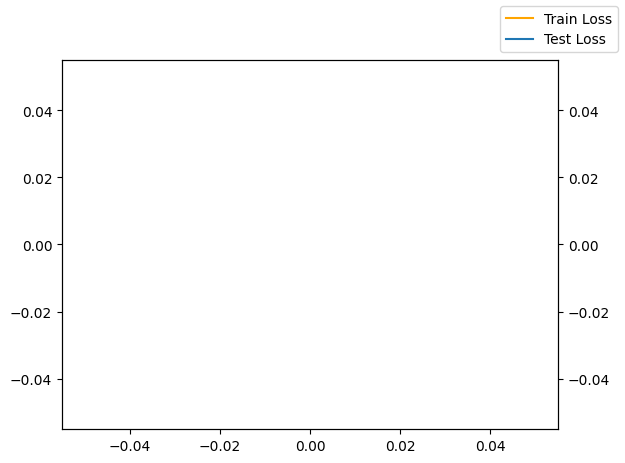

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(train_loss[20:], label = "Train Loss", color = "orange")
ax2.plot(test_loss[20:], label = "Test Loss")
fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")
plt.show()

              precision    recall  f1-score   support

           0       0.68      0.40      0.50       865
           1       0.65      0.85      0.74      1135

    accuracy                           0.66      2000
   macro avg       0.66      0.63      0.62      2000
weighted avg       0.66      0.66      0.64      2000

              precision    recall  f1-score   support

           0       0.65      0.46      0.54       865
           1       0.66      0.81      0.73      1135

    accuracy                           0.66      2000
   macro avg       0.66      0.63      0.63      2000
weighted avg       0.66      0.66      0.65      2000

              precision    recall  f1-score   support

           0       0.63      0.51      0.57       865
           1       0.68      0.77      0.72      1135

    accuracy                           0.66      2000
   macro avg       0.66      0.64      0.65      2000
weighted avg       0.66      0.66      0.66      2000

              preci

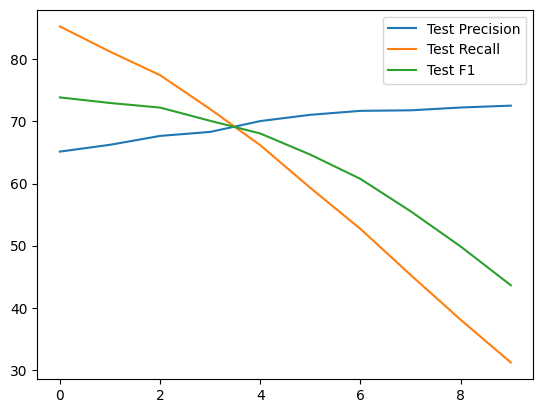

In [ ]:
prs = []
rec = []
f1 = []
loss = []

for i in np.arange(3, 4, 0.1):
    l, p, r, f, _, _, _ = sm_net.evaluate(i)
    prs.append(p)
    rec.append(r)
    f1.append(f)
    loss.append(l)

plt.plot(prs, label = "Test Precision")
plt.plot(rec, label = "Test Recall")
plt.plot(f1, label = "Test F1")

plt.legend()
plt.show()

# **(Video + Audio + Text)**

In [ ]:
class SiameseNet8(nn.Module):
    def __init__(self, device = device, channel = 84):
        super(SiameseNet8, self).__init__()
        self.encoder_user = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.user_embedding_size, 1024)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1024, channel)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_item = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.item_embedding_size, 256)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(256, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_video = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.video_embedding_size, 1600)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1600, 300)),
            ('relu2', nn.LeakyReLU()),
#             ('linr3', nn.Linear(1000, 500)),
#             ('relu3', nn.LeakyReLU()),
# #             ('norm2', nn.BatchNorm1d(500)),
#             ('linr4', nn.Linear(500, 300)),
#             ('relu4', nn.LeakyReLU()),
        ]))

        self.encoder_audio = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.audio_embedding_size, 600)),
            ('relu1', nn.LeakyReLU()),
            ('linr4', nn.Linear(600, 300)),
            ('relu4', nn.LeakyReLU()),
        ]))

        self.encoder_text = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.text_embedding_size, 256)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(256, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))

        #self.encoder_meta = nn.Sequential(OrderedDict([
        #   ('linr1', nn.Linear(train_dataset.meta_embedding_size, 1600)),
        #    ('relu1', nn.LeakyReLU()),
#             ('norm1', nn.BatchNorm1d(1600)),
        #    ('linr2', nn.Linear(1600, 300)),
        #    ('relu2', nn.LeakyReLU()),
#             ('linr3', nn.Linear(1000, 500)),
#             ('relu3', nn.LeakyReLU()),
#             ('linr4', nn.Linear(500, 300)),
#             ('relu4', nn.LeakyReLU()),
        #]))

        self.fusion = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, 1, (20, 20), stride=(2, 2))),
            ('relu1', nn.LeakyReLU()),
            ('conv2', nn.Conv2d(1, 1, (5, 50), stride=(1, 1))),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.siamese = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(channel, 200)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(200, 256)),
            ('relu2', nn.LeakyReLU()),
            ('linr3', nn.Linear(256, 100)),
            ('relu3', nn.LeakyReLU()),
        ]))

        self.ffn = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(300, 164)),
            ('actv1', nn.ReLU()),
            ('linr2', nn.Linear(164, 1)),
#             ('actv2', nn.ReLU()),
#             ('linr3', nn.Linear(50, 1)),
        ]))

        self.device = device
        self.encoder_user.apply(self.init_weights)
        self.encoder_item.apply(self.init_weights)
        self.encoder_video.apply(self.init_weights)
        self.encoder_audio.apply(self.init_weights)
        self.encoder_text.apply(self.init_weights)
        #self.encoder_meta.apply(self.init_weights)
        self.siamese.apply(self.init_weights)
        self.ffn.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

    def exp(self, q, k, v):
        z = torch.bmm(q, k.permute(0, 2, 1))
        z = F.normalize(z, p = 10, dim = 1)
        z = torch.softmax(z, 1)
        z = torch.bmm(z, v)
        return(z)

    def forward(self, x1, x2):
        # Modality-encoders
        outu = self.encoder_user(x1)
        outr = self.encoder_item(x2[3])
        outv = torch.split(self.encoder_video(x2[0]), [100, 100, 100], 1)
        outa = torch.split(self.encoder_audio(x2[1]), [100, 100, 100], 1)
        outt = torch.split(self.encoder_text(x2[2]), 100, 1)
        #outm = torch.split(self.encoder_meta(x2[4]), [100, 100, 100], 1)

        # Attention
        q_t = outt[0].unsqueeze(1).repeat(1, ROW, 1)
        k_t = outt[1].unsqueeze(1).repeat(1, ROW, 1)
        v_t = outt[2].unsqueeze(1).repeat(1, ROW, 1)

        q_a = outa[0].unsqueeze(1).repeat(1, ROW, 1)
        k_a = outa[1].unsqueeze(1).repeat(1, ROW, 1)
        v_a = outa[2].unsqueeze(1).repeat(1, ROW, 1)

        q_v = outv[0].unsqueeze(1).repeat(1, ROW, 1)
        k_v = outv[1].unsqueeze(1).repeat(1, ROW, 1)
        v_v = outv[2].unsqueeze(1).repeat(1, ROW, 1)

        #q_m = outm[0].unsqueeze(1).repeat(1, ROW, 1)
        #k_m = outm[1].unsqueeze(1).repeat(1, ROW, 1)
        #v_m = outm[2].unsqueeze(1).repeat(1, ROW, 1)

        # Self-Attention
        st = self.exp(q_t, k_t, v_t)
        #sm = self.exp(q_m, k_m, v_m)
        sa = self.exp(q_a, k_a, v_a)
        sv = self.exp(q_v, k_v, v_v)

        # Inter-Modal Attention
        ita = self.exp(q_a, k_t, v_a)
        imv = self.exp(q_v, k_a, v_v)
        #itm = self.exp(q_m, k_t, v_m)

        # Forward
        ma = torch.mean(torch.stack([sa, ita]), 0)
        mv = torch.mean(torch.stack([sv, imv]), 0)
        sda = ita
        se = torch.mul(ma, mv)
        outi = torch.cat((sda, se), axis = 2)#.reshape(-1, ROW * 1200)
        outi = self.fusion(outi.unsqueeze(1))
        out1 = self.siamese(outu)
        out2 = self.siamese(outi.reshape(BATCH, -1))
        diff = torch.cat((out1, out2, outt[2]), axis=1)
        out = self.ffn(diff)
        return(out, out1, out2)

    def fit(self, trainloader = trainloader,
            testloader = testloader, epochs = 20):
        self.criterion_rate = weighted_mse_loss
        self.criterion_embd = nn.CosineEmbeddingLoss()
        self.optimizer = optim.Adam(self.parameters(), lr = 1e-4)

        train_loss = []
        train_f1 = []
        test_loss = []
        test_f1 = []
        for epoch in range(epochs):
            running_loss = 0.0
            running_loss_1 = 0.0

            for i, data in tqdm(enumerate(trainloader)):
                self.train()
                x1, x2, y = data
                y_flt = y.type(torch.FloatTensor).to(device)
                y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
                self.optimizer.zero_grad()
                reg, outu, outi = self.forward(x1, x2)
                loss_1, loss_ = self.criterion_rate(reg.squeeze(), y_flt)
                loss_2 = self.criterion_embd(outu, outi, y_lng * 2 - 1)
                loss = loss_1 + loss_2
                loss.backward()
                self.optimizer.step()

                running_loss_1 += torch.sqrt(loss_)
                running_loss += loss
            vl, vp, vr, vf, tp, tr, tf = self.evaluate()
            print('Epoch-%d: Loss = %.3f\nTrain RMSE = %.3f||Train Precision = %.3f||Train Recall = %.3f\nTest RMSE = %.3f || Test Precision = %.3f|| Test Recall = %.3f'%
                  (epoch + 1, running_loss / i, running_loss_1 / i,
                   tp, tr, vl, vp, vr))
            train_loss.append((running_loss_1 / i).cpu().detach().numpy())
            test_loss.append(vl.cpu().detach().numpy())
            train_f1.append(tf)
            test_f1.append(vf)
        return(train_loss, test_loss, train_f1, test_f1)

    def evaluate(self, k = 3.5):
        self.eval()
        with torch.no_grad():
            valdata = next(iter(testloader))
            x1, x2, y = valdata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            vl = torch.sqrt(self.criterion_rate(otpt[0].squeeze(), y_flt)[1])
            vp = precision_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            vr = recall_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            vf = f1_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            print(classification_report(y_lng.cpu(), pred.cpu(),
                    target_names = ["0", "1"], zero_division = 0))

            traindata = next(iter(trainloader))
            x1, x2, y = traindata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            tp = precision_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            tr = recall_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            tf = f1_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
        return(vl, vp*100, vr*100, vf*100, tp*100, tr*100, tf*100)

In [ ]:
sm_net = SiameseNet8()
sm_net.to(device)

In [ ]:
train_loss, test_loss, train_f1, test_f1 = sm_net.fit()

In [ ]:
sm_net.evaluate(k=3.5)

<ipython-input-61-abf663b56279>:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")


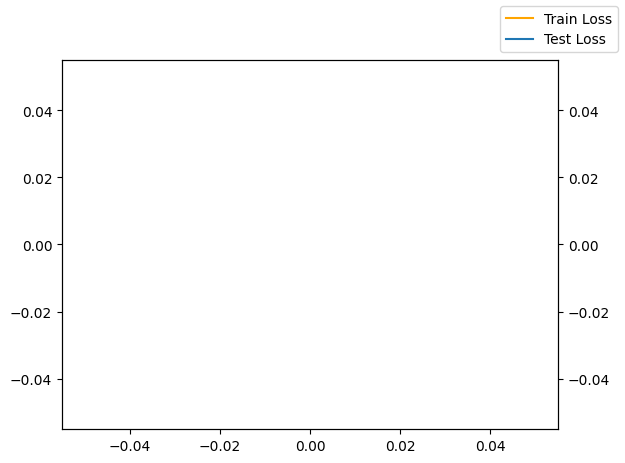

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(train_loss[20:], label = "Train Loss", color = "orange")
ax2.plot(test_loss[20:], label = "Test Loss")
fig.legend([ax, ax2], labels = ["Train Loss", "Test Loss"], loc = "upper right")
plt.show()

              precision    recall  f1-score   support

           0       0.66      0.53      0.59       865
           1       0.69      0.80      0.74      1135

    accuracy                           0.68      2000
   macro avg       0.68      0.66      0.66      2000
weighted avg       0.68      0.68      0.67      2000

              precision    recall  f1-score   support

           0       0.63      0.59      0.61       865
           1       0.70      0.74      0.72      1135

    accuracy                           0.68      2000
   macro avg       0.67      0.66      0.67      2000
weighted avg       0.67      0.68      0.67      2000

              precision    recall  f1-score   support

           0       0.62      0.65      0.64       865
           1       0.72      0.69      0.71      1135

    accuracy                           0.68      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.68      0.68      0.68      2000

              preci

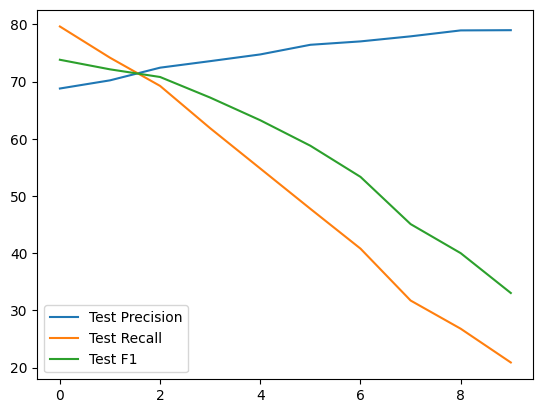

In [ ]:
prs = []
rec = []
f1 = []
loss = []

for i in np.arange(3, 4, 0.1):
    l, p, r, f, _, _, _ = sm_net.evaluate(i)
    prs.append(p)
    rec.append(r)
    f1.append(f)
    loss.append(l)

plt.plot(prs, label = "Test Precision")
plt.plot(rec, label = "Test Recall")
plt.plot(f1, label = "Test F1")

plt.legend()
plt.show()

# **(Meta + Text + Video)**

In [ ]:
class SiameseNet9(nn.Module):
    def __init__(self, device = device, channel = 84):
        super(SiameseNet9, self).__init__()
        self.encoder_user = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.user_embedding_size, 1024)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1024, channel)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_item = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.item_embedding_size, 256)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(256, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_video = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.video_embedding_size, 1600)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(1600, 300)),
            ('relu2', nn.LeakyReLU()),
#             ('linr3', nn.Linear(1000, 500)),
#             ('relu3', nn.LeakyReLU()),
# #             ('norm2', nn.BatchNorm1d(500)),
#             ('linr4', nn.Linear(500, 300)),
#             ('relu4', nn.LeakyReLU()),
        ]))

        #self.encoder_audio = nn.Sequential(OrderedDict([
        #    ('linr1', nn.Linear(train_dataset.audio_embedding_size, 600)),
        #    ('relu1', nn.LeakyReLU()),
        #    ('linr4', nn.Linear(600, 300)),
        #    ('relu4', nn.LeakyReLU()),
        #]))

        self.encoder_text = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.text_embedding_size, 256)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(256, 300)),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.encoder_meta = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(train_dataset.meta_embedding_size, 1600)),
            ('relu1', nn.LeakyReLU()),
#             ('norm1', nn.BatchNorm1d(1600)),
            ('linr2', nn.Linear(1600, 300)),
            ('relu2', nn.LeakyReLU()),
#             ('linr3', nn.Linear(1000, 500)),
#             ('relu3', nn.LeakyReLU()),
#             ('linr4', nn.Linear(500, 300)),
#             ('relu4', nn.LeakyReLU()),
        ]))

        self.fusion = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1, 1, (20, 20), stride=(2, 2))),
            ('relu1', nn.LeakyReLU()),
            ('conv2', nn.Conv2d(1, 1, (5, 50), stride=(1, 1))),
            ('relu2', nn.LeakyReLU()),
        ]))

        self.siamese = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(channel, 200)),
            ('relu1', nn.LeakyReLU()),
            ('linr2', nn.Linear(200, 256)),
            ('relu2', nn.LeakyReLU()),
            ('linr3', nn.Linear(256, 100)),
            ('relu3', nn.LeakyReLU()),
        ]))

        self.ffn = nn.Sequential(OrderedDict([
            ('linr1', nn.Linear(300, 164)),
            ('actv1', nn.ReLU()),
            ('linr2', nn.Linear(164, 1)),
#             ('actv2', nn.ReLU()),
#             ('linr3', nn.Linear(50, 1)),
        ]))

        self.device = device
        self.encoder_user.apply(self.init_weights)
        self.encoder_item.apply(self.init_weights)
        self.encoder_video.apply(self.init_weights)
        #self.encoder_audio.apply(self.init_weights)
        self.encoder_text.apply(self.init_weights)
        self.encoder_meta.apply(self.init_weights)
        self.siamese.apply(self.init_weights)
        self.ffn.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

    def exp(self, q, k, v):
        z = torch.bmm(q, k.permute(0, 2, 1))
        z = F.normalize(z, p = 10, dim = 1)
        z = torch.softmax(z, 1)
        z = torch.bmm(z, v)
        return(z)

    def forward(self, x1, x2):
        # Modality-encoders
        outu = self.encoder_user(x1)
        outr = self.encoder_item(x2[3])
        outv = torch.split(self.encoder_video(x2[0]), [100, 100, 100], 1)
        #outa = torch.split(self.encoder_audio(x2[1]), [100, 100, 100], 1)
        outt = torch.split(self.encoder_text(x2[2]), 100, 1)
        outm = torch.split(self.encoder_meta(x2[4]), [100, 100, 100], 1)

        # Attention
        q_t = outt[0].unsqueeze(1).repeat(1, ROW, 1)
        k_t = outt[1].unsqueeze(1).repeat(1, ROW, 1)
        v_t = outt[2].unsqueeze(1).repeat(1, ROW, 1)

        #q_a = outa[0].unsqueeze(1).repeat(1, ROW, 1)
        #k_a = outa[1].unsqueeze(1).repeat(1, ROW, 1)
        #v_a = outa[2].unsqueeze(1).repeat(1, ROW, 1)

        q_v = outv[0].unsqueeze(1).repeat(1, ROW, 1)
        k_v = outv[1].unsqueeze(1).repeat(1, ROW, 1)
        v_v = outv[2].unsqueeze(1).repeat(1, ROW, 1)

        q_m = outm[0].unsqueeze(1).repeat(1, ROW, 1)
        k_m = outm[1].unsqueeze(1).repeat(1, ROW, 1)
        v_m = outm[2].unsqueeze(1).repeat(1, ROW, 1)

        # Self-Attention
        st = self.exp(q_t, k_t, v_t)
        sm = self.exp(q_m, k_m, v_m)
        #sa = self.exp(q_a, k_a, v_a)
        sv = self.exp(q_v, k_v, v_v)

        # Inter-Modal Attention
        #ita = self.exp(q_a, k_t, v_a)
        itt = self.exp(q_t, k_t, v_t)
        imv = self.exp(q_v, k_m, v_v)
        itm = self.exp(q_m, k_t, v_m)

        # Forward
        ma = torch.mean(torch.stack([st, itt]), 0)
        mv = torch.mean(torch.stack([sv, imv]), 0)
        sda = itm
        se = torch.mul(ma, mv)
        outi = torch.cat((sda, se), axis = 2)#.reshape(-1, ROW * 1200)
        outi = self.fusion(outi.unsqueeze(1))
        out1 = self.siamese(outu)
        out2 = self.siamese(outi.reshape(BATCH, -1))
        diff = torch.cat((out1, out2, outm[2]), axis=1)
        out = self.ffn(diff)
        return(out, out1, out2)

    def fit(self, trainloader = trainloader,
            testloader = testloader, epochs = 20):
        self.criterion_rate = weighted_mse_loss
        self.criterion_embd = nn.CosineEmbeddingLoss()
        self.optimizer = optim.Adam(self.parameters(), lr = 1e-4)

        train_loss = []
        train_f1 = []
        test_loss = []
        test_f1 = []
        for epoch in range(epochs):
            running_loss = 0.0
            running_loss_1 = 0.0

            for i, data in tqdm(enumerate(trainloader)):
                self.train()
                x1, x2, y = data
                y_flt = y.type(torch.FloatTensor).to(device)
                y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
                self.optimizer.zero_grad()
                reg, outu, outi = self.forward(x1, x2)
                loss_1, loss_ = self.criterion_rate(reg.squeeze(), y_flt)
                loss_2 = self.criterion_embd(outu, outi, y_lng * 2 - 1)
                loss = loss_1 + loss_2
                loss.backward()
                self.optimizer.step()

                running_loss_1 += torch.sqrt(loss_)
                running_loss += loss
            vl, vp, vr, vf, tp, tr, tf = self.evaluate()
            print('Epoch-%d: Loss = %.3f\nTrain RMSE = %.3f||Train Precision = %.3f||Train Recall = %.3f\nTest RMSE = %.3f || Test Precision = %.3f|| Test Recall = %.3f'%
                  (epoch + 1, running_loss / i, running_loss_1 / i,
                   tp, tr, vl, vp, vr))
            train_loss.append((running_loss_1 / i).cpu().detach().numpy())
            test_loss.append(vl.cpu().detach().numpy())
            train_f1.append(tf)
            test_f1.append(vf)
        return(train_loss, test_loss, train_f1, test_f1)

    def evaluate(self, k = 3.5):
        self.eval()
        with torch.no_grad():
            valdata = next(iter(testloader))
            x1, x2, y = valdata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            vl = torch.sqrt(self.criterion_rate(otpt[0].squeeze(), y_flt)[1])
            vp = precision_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            vr = recall_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            vf = f1_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            print(classification_report(y_lng.cpu(), pred.cpu(),
                    target_names = ["0", "1"], zero_division = 0))

            traindata = next(iter(trainloader))
            x1, x2, y = traindata
            y_flt = y.type(torch.FloatTensor).to(device)
            y_lng = torch.div(y, 4, rounding_mode="floor").to(device)
            otpt = self.forward(x1, x2)
            pred = (otpt[0] > k).float()
            tp = precision_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            tr = recall_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
            tf = f1_score(y_lng.cpu(), pred.cpu(), zero_division = 0)
        return(vl, vp*100, vr*100, vf*100, tp*100, tr*100, tf*100)

In [ ]:
sm_net = SiameseNet9()
sm_net.to(device)

SiameseNet9(
  (encoder_user): Sequential(
    (linr1): Linear(in_features=1220, out_features=1024, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1024, out_features=84, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_item): Sequential(
    (linr1): Linear(in_features=943, out_features=256, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=256, out_features=300, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_video): Sequential(
    (linr1): Linear(in_features=1024, out_features=1600, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=1600, out_features=300, bias=True)
    (relu2): LeakyReLU(negative_slope=0.01)
  )
  (encoder_text): Sequential(
    (linr1): Linear(in_features=384, out_features=256, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (linr2): Linear(in_features=256, out_features=300, bias=True)
    (relu2): 

In [ ]:
train_loss, test_loss, train_f1, test_f1 = sm_net.fit()

40it [03:58,  5.97s/it]


              precision    recall  f1-score   support

           0       0.43      0.98      0.60       865
           1       0.35      0.01      0.01      1135

    accuracy                           0.43      2000
   macro avg       0.39      0.50      0.31      2000
weighted avg       0.38      0.43      0.27      2000

Epoch-1: Loss = 7.280
Train RMSE = 1.936||Train Precision = 50.000||Train Recall = 0.090
Test RMSE = 1.512 || Test Precision = 35.000|| Test Recall = 0.617


40it [03:40,  5.51s/it]


              precision    recall  f1-score   support

           0       0.44      0.90      0.59       865
           1       0.63      0.13      0.21      1135

    accuracy                           0.46      2000
   macro avg       0.54      0.51      0.40      2000
weighted avg       0.55      0.46      0.38      2000

Epoch-2: Loss = 3.821
Train RMSE = 1.255||Train Precision = 75.177||Train Recall = 9.389
Test RMSE = 1.324 || Test Precision = 63.043|| Test Recall = 12.775


40it [03:27,  5.19s/it]


              precision    recall  f1-score   support

           0       0.48      0.85      0.61       865
           1       0.72      0.30      0.42      1135

    accuracy                           0.54      2000
   macro avg       0.60      0.57      0.52      2000
weighted avg       0.62      0.54      0.50      2000

Epoch-3: Loss = 3.475
Train RMSE = 1.193||Train Precision = 75.921||Train Recall = 24.453
Test RMSE = 1.250 || Test Precision = 71.975|| Test Recall = 29.868


40it [03:27,  5.19s/it]


              precision    recall  f1-score   support

           0       0.50      0.85      0.63       865
           1       0.75      0.34      0.47      1135

    accuracy                           0.56      2000
   macro avg       0.63      0.60      0.55      2000
weighted avg       0.64      0.56      0.54      2000

Epoch-4: Loss = 3.196
Train RMSE = 1.142||Train Precision = 78.270||Train Recall = 32.832
Test RMSE = 1.219 || Test Precision = 75.337|| Test Recall = 34.449


40it [03:35,  5.39s/it]


              precision    recall  f1-score   support

           0       0.54      0.72      0.62       865
           1       0.71      0.53      0.60      1135

    accuracy                           0.61      2000
   macro avg       0.62      0.62      0.61      2000
weighted avg       0.64      0.61      0.61      2000

Epoch-5: Loss = 2.971
Train RMSE = 1.108||Train Precision = 75.857||Train Recall = 50.410
Test RMSE = 1.169 || Test Precision = 71.156|| Test Recall = 52.599


40it [03:27,  5.18s/it]


              precision    recall  f1-score   support

           0       0.55      0.71      0.62       865
           1       0.72      0.56      0.63      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.65      0.63      0.63      2000

Epoch-6: Loss = 2.826
Train RMSE = 1.082||Train Precision = 77.850||Train Recall = 53.327
Test RMSE = 1.162 || Test Precision = 72.041|| Test Recall = 56.300


40it [03:28,  5.22s/it]


              precision    recall  f1-score   support

           0       0.54      0.75      0.63       865
           1       0.73      0.52      0.61      1135

    accuracy                           0.62      2000
   macro avg       0.64      0.64      0.62      2000
weighted avg       0.65      0.62      0.62      2000

Epoch-7: Loss = 2.717
Train RMSE = 1.062||Train Precision = 77.253||Train Recall = 50.093
Test RMSE = 1.172 || Test Precision = 73.300|| Test Recall = 52.247


40it [03:35,  5.38s/it]


              precision    recall  f1-score   support

           0       0.57      0.72      0.63       865
           1       0.73      0.58      0.65      1135

    accuracy                           0.64      2000
   macro avg       0.65      0.65      0.64      2000
weighted avg       0.66      0.64      0.64      2000

Epoch-8: Loss = 2.655
Train RMSE = 1.057||Train Precision = 78.210||Train Recall = 53.269
Test RMSE = 1.148 || Test Precision = 72.848|| Test Recall = 58.150


40it [03:27,  5.19s/it]


              precision    recall  f1-score   support

           0       0.56      0.72      0.63       865
           1       0.72      0.56      0.63      1135

    accuracy                           0.63      2000
   macro avg       0.64      0.64      0.63      2000
weighted avg       0.65      0.63      0.63      2000

Epoch-9: Loss = 2.584
Train RMSE = 1.047||Train Precision = 78.900||Train Recall = 54.893
Test RMSE = 1.154 || Test Precision = 72.398|| Test Recall = 56.388


40it [03:29,  5.23s/it]


              precision    recall  f1-score   support

           0       0.56      0.77      0.65       865
           1       0.75      0.53      0.62      1135

    accuracy                           0.64      2000
   macro avg       0.66      0.65      0.64      2000
weighted avg       0.67      0.64      0.63      2000

Epoch-10: Loss = 2.548
Train RMSE = 1.044||Train Precision = 78.382||Train Recall = 48.587
Test RMSE = 1.154 || Test Precision = 75.469|| Test Recall = 53.128


40it [03:33,  5.33s/it]


              precision    recall  f1-score   support

           0       0.56      0.77      0.65       865
           1       0.75      0.54      0.63      1135

    accuracy                           0.64      2000
   macro avg       0.65      0.65      0.64      2000
weighted avg       0.67      0.64      0.64      2000

Epoch-11: Loss = 2.504
Train RMSE = 1.041||Train Precision = 79.885||Train Recall = 50.135
Test RMSE = 1.152 || Test Precision = 75.061|| Test Recall = 53.833


40it [03:28,  5.20s/it]


              precision    recall  f1-score   support

           0       0.58      0.69      0.63       865
           1       0.72      0.63      0.67      1135

    accuracy                           0.65      2000
   macro avg       0.65      0.66      0.65      2000
weighted avg       0.66      0.65      0.65      2000

Epoch-12: Loss = 2.474
Train RMSE = 1.037||Train Precision = 77.157||Train Recall = 57.938
Test RMSE = 1.143 || Test Precision = 72.358|| Test Recall = 62.731


40it [03:32,  5.31s/it]


              precision    recall  f1-score   support

           0       0.57      0.74      0.64       865
           1       0.75      0.57      0.65      1135

    accuracy                           0.65      2000
   macro avg       0.66      0.66      0.65      2000
weighted avg       0.67      0.65      0.65      2000

Epoch-13: Loss = 2.454
Train RMSE = 1.035||Train Precision = 79.195||Train Recall = 52.820
Test RMSE = 1.143 || Test Precision = 74.512|| Test Recall = 57.181


40it [03:30,  5.27s/it]


              precision    recall  f1-score   support

           0       0.60      0.67      0.63       865
           1       0.72      0.65      0.69      1135

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.67      0.66      0.66      2000

Epoch-14: Loss = 2.441
Train RMSE = 1.034||Train Precision = 79.429||Train Recall = 61.888
Test RMSE = 1.131 || Test Precision = 72.461|| Test Recall = 65.374


40it [03:30,  5.25s/it]


              precision    recall  f1-score   support

           0       0.59      0.68      0.63       865
           1       0.73      0.64      0.68      1135

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.67      0.66      0.66      2000

Epoch-15: Loss = 2.425
Train RMSE = 1.032||Train Precision = 76.995||Train Recall = 59.963
Test RMSE = 1.135 || Test Precision = 72.563|| Test Recall = 63.612


40it [03:30,  5.25s/it]


              precision    recall  f1-score   support

           0       0.57      0.77      0.65       865
           1       0.76      0.56      0.64      1135

    accuracy                           0.65      2000
   macro avg       0.66      0.66      0.65      2000
weighted avg       0.68      0.65      0.65      2000

Epoch-16: Loss = 2.418
Train RMSE = 1.030||Train Precision = 79.207||Train Recall = 51.375
Test RMSE = 1.143 || Test Precision = 75.837|| Test Recall = 55.859


40it [03:28,  5.21s/it]


              precision    recall  f1-score   support

           0       0.59      0.73      0.65       865
           1       0.75      0.61      0.67      1135

    accuracy                           0.66      2000
   macro avg       0.67      0.67      0.66      2000
weighted avg       0.68      0.66      0.66      2000

Epoch-17: Loss = 2.404
Train RMSE = 1.030||Train Precision = 80.856||Train Recall = 57.270
Test RMSE = 1.128 || Test Precision = 74.620|| Test Recall = 60.617


40it [03:33,  5.33s/it]


              precision    recall  f1-score   support

           0       0.58      0.74      0.65       865
           1       0.75      0.59      0.66      1135

    accuracy                           0.65      2000
   macro avg       0.66      0.67      0.65      2000
weighted avg       0.68      0.65      0.65      2000

Epoch-18: Loss = 2.398
Train RMSE = 1.027||Train Precision = 77.951||Train Recall = 54.537
Test RMSE = 1.139 || Test Precision = 75.056|| Test Recall = 58.590


40it [03:28,  5.21s/it]


              precision    recall  f1-score   support

           0       0.57      0.76      0.65       865
           1       0.76      0.57      0.65      1135

    accuracy                           0.65      2000
   macro avg       0.66      0.66      0.65      2000
weighted avg       0.68      0.65      0.65      2000

Epoch-19: Loss = 2.391
Train RMSE = 1.028||Train Precision = 79.536||Train Recall = 50.321
Test RMSE = 1.143 || Test Precision = 75.558|| Test Recall = 56.652


40it [03:28,  5.21s/it]


              precision    recall  f1-score   support

           0       0.58      0.72      0.65       865
           1       0.74      0.60      0.66      1135

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.65      2000
weighted avg       0.67      0.66      0.66      2000

Epoch-20: Loss = 2.394
Train RMSE = 1.027||Train Precision = 78.689||Train Recall = 57.091
Test RMSE = 1.130 || Test Precision = 74.159|| Test Recall = 60.176


In [ ]:
sm_net.evaluate(k=3.5)

              precision    recall  f1-score   support

           0       0.58      0.72      0.65       865
           1       0.74      0.60      0.66      1135

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.65      2000
weighted avg       0.67      0.66      0.66      2000



(tensor(1.1296),
 74.1585233441911,
 60.176211453744486,
 66.43968871595331,
 80.62418725617685,
 56.56934306569343,
 66.48793565683646)